# Deep Learning

Group members:
- Astolfi Alex (239840)
- Corte Pause Manuela (240183)
- Zocca Guglielmo

In [ ]:
%pip install ftfy regex tqdm ultralytics wandb albumentations
%pip install git+https://github.com/openai/CLIP.git

In [ ]:
import gc
import gzip
import html
import json
import math
import os
import pickle
import random
import re
from dataclasses import dataclass
from enum import Enum
from functools import lru_cache
from pprint import pprint
from typing import (
    Any,
    Callable,
    Dict,
    Iterator,
    List,
    Optional,
    OrderedDict,
    Tuple,
    Union,
)

import albumentations as A
import clip
import cv2
import ftfy
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pkg_resources as p
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as FT
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image
from torch import Tensor, device, tensor
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.ops import (
    box_convert,
    box_iou,
    distance_box_iou_loss,
    generalized_box_iou_loss,
    clip_boxes_to_image
)
from tqdm.notebook import tqdm
from ultralytics import YOLO
from ultralytics.yolo.engine.results import Results
from torchvision.utils import draw_bounding_boxes

import wandb

In [ ]:
%cd /content/
# Download dataset and save under data/raw/ only if not already downloaded
url = "https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq"
if not os.path.exists("data/raw/refcocog.tar.gz"):
    print("Downloading dataset...")
    gdown.download(url=url, output="data/raw/", quiet=False, resume=True)
if not os.path.exists("data/raw/refcocog/"):
    print("Extracting dataset...")
    !tar -xf data/raw/refcocog.tar.gz -C data/raw

Instead of linking the images with the corresponding captions and bounding boxes each time we need to run the code, we created json files, one for each spilt, that contain the image paths and the corresponding captions and bounding boxes, allowing us to can load the data faster and easier. If we prefer to create the dataset on the fly, we just need to put the preprocess option in the dataset constructor to False.

In [ ]:
# Download preprocessed dataset
url = "https://drive.google.com/drive/folders/1jaJV40dneOckZn7WHMQyd2jBh7A8534N"
gdown.download_folder(url=url, output="data/", quiet=False)

In [ ]:
# Download config files, model and tokenizer
!wget https://raw.githubusercontent.com/ManuelaCorte/DLProject/master/config.json
!wget https://raw.githubusercontent.com/ManuelaCorte/DLProject/master/sweep_config.json
!wget https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt

Since the code was originally structured as a [repo](https://github.com/ManuelaCorte/DLProject), the following cell is used simply to recreate the original structure so that the relative imports are still valid.

In [ ]:
%mkdir src
%cd src

## RefCoCog

The RefCoCo dataset [Yu, 2016](https://arxiv.org/abs/1608.00272) was collected to obtain a referring expression dataset focused on purely appearance based description, e.g., “the man in the yellow polka-dotted shirt” rather than “the second man from the left”, which tend to be more interesting from a computer vision based perspective and are independent of viewer perspective.
RefCoCog dataset was collected on Amazon Mechanical Turk in a
non-interactive setting. One set of workers were asked to write natural language
referring expressions for objects in MSCOCO images then another set of workers
were asked to click on the indicated object given a referring expression. If the click
overlapped with the correct object then the referring expression was considered
valid and added to the dataset. If not, another referring expression was collected
for the object. This dataset consists of 85,474 referring expressions for 54,822
objects in 26,711 images. Images were selected to contain between 2 and 4 objects
of the same object category. RefCOCOg expressions has an average length of 8.43 words.
RefCOCOg contains an average of 1.63 same-type objects per image. The data are splited in  sets through a per-object split. In this split, the dataset is divided by
randomly partitioning objects into training and testing sets. This means that
each object will only appear either in training or testing set, but that one object
from an image may appear in the training set while another object from the
same image may appear in the test set.  

### Structure of the dataset:

- refcocog
    - annotations
        - instances.json: informations about the images, the bounding box, segmentation and category of dataset.
            - images: information about the names, the heighs, the widths and ids of images.
            - annotations: information about the segmantation, bounding box, area and category of an object in a image (identified with an id) in accordance with a reference sentence identified with an id.
            - categories: categories of the objects identified in the images of the dataset.
        - refs(google).p: reference sentences (collected by google) identified by an id, "ann_id". It splits the sentences in validation and train set. Associated to every sentences there are the category of object refered, the file name and id of the image to which the sentence refers.
        - refs(umd).p: reference sentences. It splits the sentences in validation, train and test set. Associated to every sentences there are the category of object refered, the file name and id of the image to which the sentence refers.
    - images: contains all images of the datasets.

Here we show an example of an image in the dataset, with its bounding box and the corresponding longest caption.

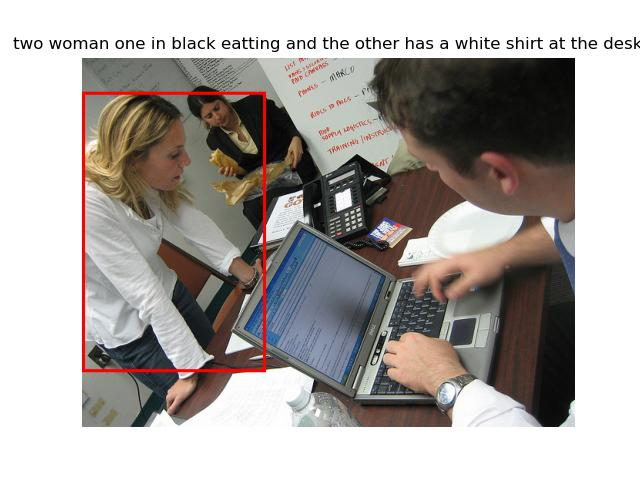

## Dataset class

Below are some utility classes that define the structure of a dataset sample (i.e. image path, bounding box and caption) and that of a batch sample (i.e. image tensor and tokenized caption).

**Sample class**
- `image_path`: relative path to the image in the dataset
- `caption`: from all sentences describing the image we choose the longest one as it should be the one containing the most information
- `bbox`: bounding box of the object of interest in the image in the format [x, y, w, h]

**BatchSample class**
- `image`: tensor of shape (3, 224, 224) containing the image
- `caption`: the caption is first extended the prompt *"find the region that corresponds to the description {caption}"* similarly to what was done in [Jiang, 2022](http://arxiv.org/abs/2203.08481) and then turned into a list of integers using CLIP's tokenizer

In [ ]:
class Sample:
    def __init__(self, image_path: str, caption: str, bounding_box: Tensor) -> None:
        self.image_path = image_path
        self.caption = caption
        self.bounding_box = bounding_box

    def as_dict(self) -> dict[str, Any]:
        return {
            "image_path": self.image_path,
            "caption": self.caption,
            "bounding_box": self.bounding_box.tolist(),
        }

    @staticmethod
    def fromJSON(json: dict[str, Any]) -> Any:
        return Sample(json["image_path"], json["caption"], Tensor(json["bounding_box"]))


class BatchSample:
    def __init__(self, image: Tensor, caption: Tensor) -> None:
        self.image: Tensor = image
        self.caption: Tensor = caption

    def to(self, device: device | str) -> Any:
        return self.__class__(self.image.to(device), self.caption.to(device))

    def __str__(self) -> str:
        return f"BatchSample(image={self.image.shape}, caption={self.caption.shape})"


@dataclass(frozen=True)
class Split(Enum):
    TRAIN = "train"
    VAL = "val"
    TEST = "test"


# Used in the baseline model
# Returns the bounding box with the highest score
# among all the bounding boxes detected by YOLO
@dataclass(frozen=True)
class Result:
    bounding_box: Tensor
    score: Tensor


# XYXY: top left and bottom right corners
# XYWH: top left corner, width and height
# CXCWH: center coordinates, width and height
@dataclass(frozen=True)
class BboxType(Enum):
    XYXY = "xyxy"
    XYWH = "xywh"
    CXCWH = "cxcwh"

    def __str__(self) -> str:
        return super().__str__()

In [ ]:
# The Dataset contains samples with an image with a bounding box and a caption associated with the bounding box.
class VGDataset(Dataset[Tuple[BatchSample, Tensor]]):
    def __init__(
        self,
        dir_path: str,
        split: Split,
        output_bbox_type: BboxType,
        # Augmentation is only applied to the training set
        augment: bool,
        # Necessary for using with both our model and the baseline
        transform: bool = True,
        preprocessed: bool = False,
        preprocessed_path: str = "../data/processed/",
    ) -> None:
        super().__init__()
        self.dir_path: str = dir_path
        self.split: Split = split
        self.output_bbox_type: BboxType = output_bbox_type
        self.augment: bool = augment
        self.transform: bool = transform
        self.device: device = torch.device(
            device="cuda" if torch.cuda.is_available() else "cpu"
        )

        # Load preprocessed dataset
        if preprocessed:
            preprocess(dir_path, preprocessed_path, output_bbox_type)
            with open(
                preprocessed_path + f"{self.split.value}_samples.json", "rb"
            ) as samples:
                self.samples: List[Sample] = json.load(
                    samples, object_hook=Sample.fromJSON
                )
        else:
            self.samples: List[Sample] = self.get_samples()  # type: ignore

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, ref_id: int) -> Tuple[BatchSample, Tensor]:
        if self.transform:
            # Add prefix as described in pseudoQ
            extended_caption: str = f"find the region that corresponds to the description {self.samples[ref_id].caption}"
            caption: Tensor = clip.tokenize(extended_caption, truncate=True)  # type: ignore
            image, bbox = transform_sample(
                Image.open(self.samples[ref_id].image_path),
                self.samples[ref_id].bounding_box,
                self.augment,
            )
        else:
            caption: Tensor = clip.tokenize(self.samples[ref_id].caption, truncate=True)  # type: ignore
            image = read_image(self.samples[ref_id].image_path)
            bbox = self.samples[ref_id].bounding_box
        return BatchSample(image, caption), bbox

    def get_samples(self) -> List[Sample]:
        with open(self.dir_path + "annotations/instances.json", "r") as inst, open(
            self.dir_path + "annotations/refs(umd).p", "rb"
        ) as refs:
            instances = json.load(inst)
            references = pickle.load(refs)

        samples: List[Sample] = []
        for ref in references:
            if self.split.value == ref["split"]:
                image_path = self.get_image_path(ref["image_id"], instances)
                caption = self.get_caption(ref["sentences"])
                bbox = self.get_bounding_box(ref["ann_id"], instances)
                samples.append(Sample(image_path, caption, bbox))
        return samples

    def get_image_path(self, img_id: int, instances: Dict[str, Any]) -> str:
        # Itereate over all images until we find the one with the given id
        image_name = next(
            image["file_name"] for image in instances["images"] if image["id"] == img_id
        )
        path = self.dir_path + "images/" + image_name
        return path

    def get_caption(self, captions: List[Dict[str, Any]]) -> str:
        longest_caption = captions[0]
        for caption in captions:
            if len(caption["sent"]) > len(longest_caption["sent"]):
                longest_caption = caption
        return longest_caption["sent"]

    # Bounding boxed converted to different formats
    def get_bounding_box(self, ann_id: int, instances: Dict[str, Any]) -> Tensor:
        bbox = next(
            ann["bbox"] for ann in instances["annotations"] if ann["id"] == ann_id
        )
        bounding_box: Tensor = tensor([])
        match self.output_bbox_type.name:
            case BboxType.XYXY.name:
                bounding_box = box_convert(
                    tensor([bbox]), in_fmt="xywh", out_fmt=BboxType.XYXY.value
                )
            case BboxType.XYWH.name:
                bounding_box = box_convert(
                    tensor([bbox]), in_fmt="xywh", out_fmt=BboxType.XYWH.value
                )
            case BboxType.CXCWH.name:
                bounding_box = box_convert(
                    tensor([bbox]), in_fmt="xywh", out_fmt=BboxType.CXCWH.value
                )

        return bounding_box

Since the return type of the `__get_item__()` method is a tuple and not a simple tensor we need to define a custom method to collate the samples in a batch. In particular, it takes a list of (BatchSample, bounding_box) tuples and returns a tuple containing a list of BatchSamples and a tensor containing the stacked bounding boxes.

In [ ]:
def custom_collate(
    batch: List[Tuple[BatchSample, torch.Tensor]]
) -> Tuple[List[BatchSample], torch.Tensor]:
    bboxes: List[torch.Tensor] = []
    samples: List[BatchSample] = []
    for sample, bbox in batch:
        samples.append(BatchSample(sample.image, sample.caption))
        bboxes.append(bbox)
    return samples, torch.stack(bboxes)

Code used to preprocess the dataset which is basically equvalent to the code used in the `VGDataset` class with the addition of saving the results in a json file.

In [ ]:
def get_samples(
    dir_path: str, bbox_type: BboxType
) -> Tuple[List[Sample], List[Sample], List[Sample]]:
    with open(dir_path + "annotations/instances.json", "r") as inst, open(
        dir_path + "annotations/refs(umd).p", "rb"
    ) as refs:
        instances = json.load(inst)
        references = pickle.load(refs)
    train_samples: List[Sample] = []
    val_samples: List[Sample] = []
    test_samples: List[Sample] = []
    for ref in tqdm(references, desc=f"Processing dataset"):
        image_path = get_image_path(dir_path, ref["image_id"], instances)
        caption = get_caption(ref["sentences"])
        bbox = get_bounding_box(ref["ann_id"], instances, bbox_type)
        split = ref["split"]

        # Iterate over all dataset and divide samples according to the split
        match split:
            case Split.TRAIN.value:
                train_samples.append(Sample(image_path, caption, bbox))
            case Split.VAL.value:
                val_samples.append(Sample(image_path, caption, bbox))
            case Split.TEST.value:
                test_samples.append(Sample(image_path, caption, bbox))
            case _:
                raise ValueError(f"Invalid split: {split}")
    return train_samples, val_samples, test_samples


def get_image_path(dir_path: str, img_id: int, instances: Dict[str, Any]) -> str:
    image_name = next(
        image["file_name"] for image in instances["images"] if image["id"] == img_id
    )
    path = dir_path + "images/" + image_name
    return path


def get_caption(captions: List[Dict[str, Any]]) -> str:
    longest_caption = captions[0]
    for caption in captions:
        if len(caption["sent"]) > len(longest_caption["sent"]):
            longest_caption = caption
    return longest_caption["sent"]


# Bounding boxed converted to format compatible with yolo or torchvision
def get_bounding_box(
    ann_id: int, instances: Dict[str, Any], bbox_type: BboxType
) -> Tensor:
    bbox = next(ann["bbox"] for ann in instances["annotations"] if ann["id"] == ann_id)
    bounding_box: Tensor = tensor([])
    match bbox_type.name:
        case BboxType.XYXY.name:
            bounding_box = box_convert(
                tensor([bbox]), in_fmt="xywh", out_fmt=BboxType.XYXY.value
            )
        case BboxType.XYWH.name:
            bounding_box = box_convert(
                tensor([bbox]), in_fmt="xywh", out_fmt=BboxType.XYWH.value
            )
        case BboxType.CXCWH.name:
            bounding_box = box_convert(
                tensor([bbox]), in_fmt="xywh", out_fmt=BboxType.CXCWH.value
            )

    return bounding_box


# If the files already exist, don't preprocess again
def preprocess(in_path: str, out_path: str, bbox_type: BboxType) -> None:
    if (
        os.path.exists(f"{out_path}train_samples.json")
        and os.path.exists(f"{out_path}val_samples.json")
        and os.path.exists(f"{out_path}test_samples.json")
    ):
        return
    train_samples, val_samples, test_samples = get_samples(in_path, bbox_type)

    json.dump(
        train_samples,
        open(f"{out_path}train_samples.json", "w"),
        default=Sample.as_dict,
    )

    json.dump(
        val_samples,
        open(f"{out_path}val_samples.json", "w"),
        default=Sample.as_dict,
    )

    json.dump(
        test_samples,
        open(f"{out_path}test_samples.json", "w"),
        default=Sample.as_dict,
    )

### Data Augmentation
The images are transformed the same way as in the original CLIP [Radford, 2020](http://arxiv.org/abs/2103.00020) in order to make them compatible with the CLIP model. In particular, we resize the images to 224x224, center crop them and normalize them using the mean and standard deviation provided in the paper.

Augmenting images for visual grounding isn't as straightforward as augmenting for other tasks such as classification. In fact, we need to make sure that the bounding boxes are still valid after the transformations and that by modifying the image the text is still describing the image. For example, if a caption says "a red car" and we augment the image by inverting the colors, the caption will no longer be valid. Thus we decided to use a external library, [Albumentation](https://albumentations.ai/docs/), so that the bouding boxes are automatically transformed when the image is transformed.

We used the following transformations as they are the ones that should not invalidate the captions:
- `ColorJitter`: by changing the brightness, contrast and saturation but not the hue we can have augmented images that still are valid wrt the captions
- `GaussianBlur`

In [ ]:
# Transform image according to CLIP preprocess function
# Normalize bounding box coordinates to be independent of image size
def transform_sample(
    image: Image.Image,
    box: Tensor,
    augment: bool,
    target_size: int = 224,
) -> Tuple[Tensor, Tensor]:
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Instead of augmenting all images, we randomly choose whether to augment or not
    if random.random() <= 0.5 and augment:
        trans = A.Compose(
            transforms=[
                A.Resize(target_size, target_size, interpolation=cv2.INTER_CUBIC, p=1),
                A.CenterCrop(
                    target_size,
                    target_size,
                    always_apply=True,
                ),
                A.Normalize(
                    mean=(0.48145466, 0.4578275, 0.40821073),
                    std=(0.26862954, 0.26130258, 0.27577711),
                    max_pixel_value=255.0,
                    always_apply=True,
                ),
                A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                A.GaussianBlur(),
                A.PixelDropout(),
                ToTensorV2(),
            ],
            # coco format is [x_min, y_min, width, height]
            bbox_params=A.BboxParams(format="coco", label_fields=[]),
        )
    else:
        # Same transformation as in the CLIP preprocess function
        trans = A.Compose(
            transforms=[
                A.Resize(target_size, target_size, interpolation=cv2.INTER_CUBIC, p=1),
                A.CenterCrop(
                    target_size,
                    target_size,
                    always_apply=True,
                ),
                A.Normalize(
                    mean=(0.48145466, 0.4578275, 0.40821073),
                    std=(0.26862954, 0.26130258, 0.27577711),
                    max_pixel_value=255.0,
                ),
                ToTensorV2(),
            ],
            # coco format is [x_min, y_min, width, height]
            bbox_params=A.BboxParams(format="coco", label_fields=[]),
        )

    transformed_sample: Dict[str, Any] = trans(  # type: ignore
        image=np.array(image), bboxes=box.tolist()
    )
    # Normalize bounding boxes in [0,1]
    bbox_tensor: Tensor = torch.tensor(transformed_sample["bboxes"][0]) / target_size
    return transformed_sample["image"], bbox_tensor.to(torch.float32)

## Baseline
The baseline consists in using [YOLOv8](https://docs.ultralytics.com/) to get candidate bounding boxes. We then crop the image based on these proposals, use CLIP to compute the similarity with the caption of the described region and return the bounding box with the higher similarity.

Compared to the baseline described in the assignment we made a slight modification, the bounding boxes predicted by YOLO are used both for cropping the image than for blurring the entire image outside of the predicted bounding box. This way even if the information outside of the box is less important because it's blurred there are still information about the position of the object in the image, similarly to what was done in [Subramanian, 2022](http://arxiv.org/abs/2204.05991).

In [ ]:
class Baseline:
    def __init__(self) -> None:
        self.device = torch.device(
            device="cuda" if torch.cuda.is_available() else "cpu"
        )
        print(f"Using device: {self.device}")
        self.clip_model: CLIP
        self.clip_preprocessor: T.Compose
        self.clip_model, self.clip_preprocessor = clip.load(
            name="RN50", device=self.device
        )
        self.yolo: YOLO = YOLO()

    def predict(self, batch: List[BatchSample]) -> List[Result]:
        images: List[Image.Image] = [T.ToPILImage()(sample.image) for sample in batch]
        batch_bbox_predictions: List[Results] = self.yolo(
            images, max_det=50, verbose=False, device=self.device
        )  # type: ignore
        results: List[Result] = []

        for sample, image_bboxes in zip(batch, batch_bbox_predictions, strict=True):
            image: Tensor = sample.image
            crops: List[Tensor] = []
            boxes: List[Tensor] = []
            blurs: List[Tensor] = []

            for bbox in image_bboxes.boxes.xyxy:
                bbox = bbox.to(self.device)
                xmin, ymin, xmax, ymax = bbox.int()

                # Check if the box is bigger than image
                if (
                    0 > xmin
                    or xmin > sample.image.shape[2]
                    or 0 > xmax
                    or xmax > sample.image.shape[2]
                    or 0 > ymin
                    or ymin > sample.image.shape[1]
                    or 0 > ymax
                    or ymax > sample.image.shape[1]
                ):
                    print(f"Box overflow image: [{xmin},{ymin},{xmax},{ymax}]")

                crops.append(image[:, ymin:ymax, xmin:xmax])
                boxes.append(bbox)
                blurred: Tensor = T.GaussianBlur(25, 50)(sample.image).to(self.device)
                blurred[:, ymin:ymax, xmin:xmax] = image[:, ymin:ymax, xmin:xmax]
                blurs.append(blurred)

            if len(crops) == 0:
                results.append(
                    Result(
                        torch.tensor([0, 0, 1, 1], device=self.device),
                        torch.tensor([0], device=self.device),
                    )
                )
                continue
            scores: Tensor = self.compute_clip_similarity(
                crops, blurs, sample.caption.to(self.device)
            )
            max_score: Tensor = torch.argmax(scores)
            results.append(Result(boxes[max_score], scores[max_score]))
        return results

    # Combination of cropping and blurring for the object proposals
    @torch.no_grad()
    def compute_clip_similarity(
        self,
        crops: List[Tensor],
        blurs: List[Tensor],
        caption: Tensor,
    ) -> Tensor:
        images_crops = torch.stack(
            [self.clip_preprocessor(T.ToPILImage()(crop)) for crop in crops]
        ).to(self.device)
        logits_img_crop, _ = self.clip_model(images_crops, caption)

        images_blurs = torch.stack(
            [self.clip_preprocessor(T.ToPILImage()(blur)) for blur in blurs]
        ).to(self.device)
        logits_img_blur, _ = self.clip_model(images_blurs, caption)

        return logits_img_crop + logits_img_blur

## Model
The architecture for our model is heavily inspired by the one used in [Wang, 2022](http://arxiv.org/abs/2111.15174).

It uses CLIP as a backbone encoder to obtain multiple visual and textual features, which are then fused together in a fusion module, fed into a decoder and finally a regression head which outputs the predicted bounding box.

Below we give further explanations for the different components.

### Backbone
Below is the code from [CLIP Repository](https://github.com/openai/CLIP). We describe here in details the changes made to the original model.

`Visual Encoder`<br>
The clip model we used takes as visual encoder a ResNet50 with some minor modifications:
- In the "stem" block it uses 3 convolutions instead of one, and substitutes max pooling with average pooling.
- It performs anti-aliasing when the stride $> 1$, by performing an average pooling between the second and third convolution in the bottelneck block and by pre-appending an average pooling to the downsampling convolution.
- It substitutes the final average pooling with a QKV attention pooling.  <br>

We additionally implemented the following modifications:
- In the **Attention Pooling** layer a residual connection is added around the attention block, in order to give more importance to the final features from the ResNet50. Moreover, the positional embeddings used in clip implementation contain a CLS token at the beginning, which we skip. Finally, the output is reshaped in order to match the residual connection dimensions, and is fed through a last activation layer. The output dimensions are thus compatible with the fusion module (see next section). <br>
- On top of the modified result from the **Attention Pooling** layer, our version also returns the output of the second and third residual blocks. This allows us to exploit the information contained in the intermediate representations of the ResNet50. The first residual block has been skipped, as the information contained in it are too low level to be useful for grouding the final object. <br>

`Text Encoder`<br>
The original text encoder consisted of a Transformer with 12 layers operating on a BPE (Byte Pair Encoding) representation of the text. Compared to the original Transformer [Vaswani, 2017](https://arxiv.org/abs/1706.03762), it's modified to move the Layer Normalization to the input of each sub-block and adds an additional Layer Normalization after the final transformer block. The activations of the final layer of the transformer at the [EOS] token are used as the text features representation. <br>
The only modification we added is in the output: our version returns the transformer output on top of the global feature representation.

In [ ]:
from collections import OrderedDict
from typing import Any, List, Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes: int, planes: int, stride: int = 1) -> None:
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(
                OrderedDict(
                    [
                        ("-1", nn.AvgPool2d(stride)),
                        (
                            "0",
                            nn.Conv2d(
                                inplanes,
                                planes * self.expansion,
                                1,
                                stride=1,
                                bias=False,
                            ),
                        ),
                        ("1", nn.BatchNorm2d(planes * self.expansion)),
                    ]
                )
            )

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


# Class modified by adding a residual connection around the attention block
# and reshaping the positional embeddings and the output
# The attention block is the same as in the original paper and isn't finetuned
class AttentionPool2d(nn.Module):
    def __init__(
        self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int
    ) -> None:
        super().__init__()
        self.spacial_dim = spacial_dim
        self.positional_embedding = nn.Parameter(
            torch.randn(spacial_dim**2 + 1, embed_dim) / embed_dim**0.5
        )
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads
        # residual
        self.connect = nn.Sequential(
            nn.Conv2d(embed_dim, output_dim, 1),
            nn.BatchNorm2d(output_dim),
        )

    def resize_pos_embed(self, pos_embed, input_shape):
        pos_h = pos_w = self.spacial_dim
        # Skip the first position embedding as it is the CLS token
        pos_embed_weight = pos_embed[:, (-1 * pos_h * pos_w) :, :]  # 1 HW C
        pos_embed_weight = pos_embed_weight.permute(0, 2, 1)
        return pos_embed_weight

    def forward(self, x):
        B, C, H, W = x.size()
        # Residual connection
        residual = self.connect(x)

        x = x.reshape(B, C, -1)  # B C HW
        pos_embed = self.positional_embedding.unsqueeze(0)
        pos_embed = self.resize_pos_embed(pos_embed, (H, W))  # 1 C HW
        x = x + pos_embed.to(x.dtype)  # B C HW
        x = x.permute(2, 0, 1)  # HW B C (seq_len, batch, embed_dim)
        x, _ = F.multi_head_attention_forward(
            query=x,
            key=x,
            value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat(
                [self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]
            ),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False,
        )
        x = x.permute(1, 2, 0).reshape(B, -1, H, W)  # B C H W
        x = x + residual
        x = F.relu(x, True)

        return x


# The only modification done is returning the intermediate features from the residual layers
class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(
        self,
        layers: List[int] | Tuple[int, int, int, int],
        output_dim: int,
        heads: int,
        input_resolution: int = 224,
        width: int = 64,
    ) -> None:
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(
            3, width // 2, kernel_size=3, stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            width // 2, width // 2, kernel_size=3, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(
            input_resolution // 32, embed_dim, heads, output_dim
        )

    def _make_layer(self, planes: int, blocks: int, stride: int = 1) -> nn.Sequential:
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        with torch.no_grad():

            def stem(x: Tensor) -> Tensor:
                x = self.relu1(self.bn1(self.conv1(x)))
                x = self.relu2(self.bn2(self.conv2(x)))
                x = self.relu3(self.bn3(self.conv3(x)))
                x = self.avgpool(x)
                return x

            x = x.type(self.conv1.weight.dtype)
            x_stem: Tensor = stem(x)
            x1: Tensor = self.layer1(x_stem)
            x2: Tensor = self.layer2(x1)
            x3: Tensor = self.layer3(x2)
            x4: Tensor = self.layer4(x3)

        x_pooled: Tensor = self.attnpool(x4)

        return (
            x2,
            x3,
            x_pooled,
        )  # B 512 H/8 W/8 (B, 1024, H/16, W/16) (B, 1024, H/32, W/32)


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, input: Tensor) -> Tensor:
        orig_type = input.dtype
        ret = super().forward(input.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(
        self, d_model: int, n_head: int, attn_mask: Optional[torch.Tensor] = None
    ) -> None:
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(
            OrderedDict(
                [
                    ("c_fc", nn.Linear(d_model, d_model * 4)),
                    ("gelu", QuickGELU()),
                    ("c_proj", nn.Linear(d_model * 4, d_model)),
                ]
            )
        )
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = (
            self.attn_mask.to(dtype=x.dtype, device=x.device)
            if self.attn_mask is not None
            else None
        )
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(
        self,
        width: int,
        layers: int,
        heads: int,
        attn_mask: Optional[torch.Tensor] = None,
    ):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(
            *[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)]
        )

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


# Modifications:
# - The encode_text method returns the transformer output on top of the global features
# - Initialization of the residual connection added in the attention pooling
class CLIP(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        # vision
        image_resolution: int,
        vision_layers: Tuple[int, int, int, int],
        vision_width: int,
        # text
        context_length: int,
        vocab_size: int,
        transformer_width: int,
        transformer_heads: int,
        transformer_layers: int,
    ):
        super().__init__()

        self.context_length = context_length

        vision_heads = vision_width * 32 // 64
        self.visual = ModifiedResNet(
            layers=vision_layers,
            output_dim=embed_dim,
            heads=vision_heads,
            input_resolution=image_resolution,
            width=vision_width,
        )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask(),
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(
            torch.empty(self.context_length, transformer_width)
        )
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features**-0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)
                nn.init.kaiming_uniform_(self.visual.attnpool.connect[0].weight)

            for resnet_block in [
                self.visual.layer1,
                self.visual.layer2,
                self.visual.layer3,
                self.visual.layer4,
            ]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width**-0.5) * (
            (2 * self.transformer.layers) ** -0.5
        )
        attn_std = self.transformer.width**-0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width**-0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image) -> Tuple[Tensor, Tensor, Tensor]:
        return self.visual(image.type(self.dtype))

    @torch.no_grad()
    def encode_text(self, text) -> Tuple[Tensor, Tensor]:
        x = self.token_embedding(text).type(
            self.dtype
        )  # B L D (batch size, sequence length=77, embed dim=512)

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # L B D
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # B L D
        x = self.ln_final(x).type(self.dtype)  # B L D

        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # Embedding corresponding to the higher value token for each element in the sequence (eot_token)
        global_repr: Tensor = (
            x[torch.arange(x.shape[0]), text.argmax(dim=-1), :] @ self.text_projection
        )  # [B, d_model=1024] @ [d_model, D] = [B, D]

        # Transformer output, EOT embeddings
        return x, global_repr

    def forward(self, image, text) -> Tuple[Tensor, Tensor]:
        image_features: Tensor = self.encode_image(image)[2]
        text_features: Tensor = self.encode_text(text)[1]

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l: nn.Module) -> None:
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [
                *[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]],
                "in_proj_bias",
                "bias_k",
                "bias_v",
            ]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr_module: nn.Module = getattr(l, name)
                if attr_module is not None:
                    attr_module.data = attr_module.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict[str, Any]):
    """Build a CLIP model from a state dict"""
    counts: List[int] = [
        len(
            set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))
        )
        for b in [1, 2, 3, 4]
    ]
    vision_layers: Tuple[int, int, int, int] = tuple(counts)  # type: ignore
    vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
    output_width = round(
        (state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5
    )
    assert (
        output_width**2 + 1
        == state_dict["visual.attnpool.positional_embedding"].shape[0]
    )
    image_resolution = output_width * 32

    embed_dim: int = state_dict["text_projection"].shape[1]
    context_length: int = state_dict["positional_embedding"].shape[0]
    vocab_size: int = state_dict["token_embedding.weight"].shape[0]
    transformer_width: int = state_dict["ln_final.weight"].shape[0]
    transformer_heads: int = transformer_width // 64
    transformer_layers: int = len(
        set(
            k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")
        )
    )

    model = CLIP(
        embed_dim,
        image_resolution,
        vision_layers,
        vision_width,
        context_length,
        vocab_size,
        transformer_width,
        transformer_heads,
        transformer_layers,
    )

    # Add the new residual connection to the state dict
    state_dict.update(
        model.visual.attnpool.connect.state_dict(prefix="visual.attnpool.connect.")
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)

    model.load_state_dict(state_dict)
    return model.eval()

### Fusion Module
The **FusionModule** allows us to fuse the features obtained from the backbone across the two modalities and retain cross-modality information. In particular, both the final visual and global text features are projected and then fused together by multplying them and then feeding them to a *norm_layer* (i.e. BatchNorm and Relu):  

$$ f_{fusion} = norm(W_{visual} \cdot f_{visual} \cdot W_{text} \cdot f_{text}) $$  

where $f_{visual}$ and $f_{text}$ are the visual and text features respectively and $W_{visual}$ and $W_{text}$ are the projection layers for the visual and text features respectively.

Since different layers of the encoder usually retain different types of informations, the obtained features are then upsampled, concatenated with the features from the third residual block and fed to a convolutional block (i.e. a convolutional layer, followed by Batch Normalization and ReLU). After a maxpooling layer, the same process is applied with the features from the second residual block. Finally, the features obtained fron the different layers are concatenated and fed to a last convolutional block to obtain an aggregate representation:  

$$ f_{l4} = upsample(f_{fusion}) $$
$$ f_{l3} = conv(concat(f_{l4}, f_{l3})) $$
$$ f_{l2} = maxpool(f_{l2}) $$
$$ f_{l2} = conv(concat(f_{l3}, f_{l2})) $$
$$ f_{agg} = conv(concat(f_{l4}, f_{l3}, f_{l2})) $$  

where $f_{l3}$ and $f_{l2}$ are the features from the third and second residual blocks respectively, $f_{agg}$ is the final aggregate representation and `conv = Sequence(Conv2d, BatchNorm2d, Relu)`.

As described in [Liu, 2018](https://arxiv.org/abs/1807.03247) and [Wang, 2022](http://arxiv.org/abs/2111.15174), we additionally add a **CoordConv** module consisitng of a fixed 2D tensor containing the coordinates of the pixels:  

$$ f_{final} = coordconv(f_{agg}) $$  
  
This way, the model can learn to ignore the translation invariance of the image (i.e. it might help to recognize the same object on the left or on the right as different objects for visual grounding).  

In [ ]:
class FusionModule(nn.Module):
    def __init__(self, emb_dim: int, clip_emb_dim: int, proj_img_size: int) -> None:
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.text_projection = nn.Sequential(
            nn.Linear(in_features=clip_emb_dim, out_features=clip_emb_dim),
            nn.BatchNorm1d(clip_emb_dim, device=self.device),
        ).to(self.device)

        self.vis_l4_projection = _conv_layer(
            input_dim=clip_emb_dim,
            output_dim=clip_emb_dim,
            kernel_size=1,
            padding=0,
            device=self.device,
        )[
            :2
        ]  # Remove ReLU

        self.norm_layer = nn.Sequential(
            nn.BatchNorm2d(
                clip_emb_dim,
                device=self.device,
            ),
            nn.ReLU(),
        ).to(self.device)

        self.vis_l3_projection = _conv_layer(
            input_dim=clip_emb_dim + clip_emb_dim,
            output_dim=emb_dim,
            kernel_size=3,
            padding=1,
            device=self.device,
        )
        self.vis_l2_projection = _conv_layer(
            input_dim=emb_dim + emb_dim,
            output_dim=emb_dim,
            kernel_size=3,
            padding=1,
            device=self.device,
        )
        self.aggregation = _conv_layer(
            input_dim=clip_emb_dim + emb_dim + emb_dim,
            output_dim=emb_dim,
            kernel_size=1,
            padding=0,
            device=self.device,
        )

        self.coord_conv = nn.Sequential(
            CoordConv(emb_dim + 2, emb_dim),
            _conv_layer(
                input_dim=emb_dim,
                output_dim=emb_dim,
                kernel_size=3,
                padding=1,
                device=self.device,
            ),
        )

    def forward(
        self, visual_features: Tuple[Tensor, Tensor, Tensor], text_features: Tensor
    ) -> Tensor:
        visual_l2_features, visual_l3_features, visual_l4_features = visual_features
        # Visual and text features projection
        text_features_proj: Tensor = (
            self.text_projection(text_features).unsqueeze(-1).unsqueeze(-1)
        )  # B 1024 1 1
        visual_l4_features_proj: Tensor = self.vis_l4_projection(
            visual_l4_features
        )  # B 1024 7 7

        # First fusion l4 (B 1024 7 7) and text (B 1024)
        fused_l4: Tensor = self.norm_layer(
            visual_l4_features_proj * text_features_proj
        )  # B 1024 7 7

        # Second fusion l3 (B 512 14 14) and l4 (B 1024 7 7)
        fused_l4_upsample: Tensor = nn.Upsample(scale_factor=2, mode="nearest")(
            fused_l4
        )  # B 1024 14 14
        cat_features: Tensor = torch.cat([visual_l3_features, fused_l4_upsample], dim=1)
        fused_l3: Tensor = self.vis_l3_projection(cat_features)  # B 512 14 14

        # Third fusion l2 (B 512 28 28) and l3 (B 512 14 14)
        visual_l2_pooling: Tensor = nn.MaxPool2d(kernel_size=2, stride=2)(
            visual_l2_features
        )  # B 512 14 14
        fused_l2: Tensor = self.vis_l2_projection(
            torch.cat([fused_l3, visual_l2_pooling], dim=1)
        )  # B 512 14 14

        # Aggregate features
        cat_visual_features: Tensor = torch.cat(
            [fused_l2, fused_l3, fused_l4_upsample], dim=1
        )  # B 2048 14 14
        aggregated_features: Tensor = self.aggregation(
            cat_visual_features
        )  # B 512 14 14

        # Add coordinate features
        final_features: Tensor = self.coord_conv(aggregated_features)  # B 512 14 14
        return final_features


# Enables the model to "ignore" the translation invariant nature of the image
class CoordConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv: nn.Sequential = _conv_layer(
            input_dim=in_channels,
            output_dim=out_channels,
            kernel_size=3,
            padding=1,
            device=self.device,
        )

    def add_coord(self, input: Tensor) -> Tensor:
        b, _, h, w = input.size()

        # Divide [-1, 1] interval into w and h equal parts respectively
        x_range = torch.linspace(-1, 1, w, device=self.device)
        y_range = torch.linspace(-1, 1, h, device=self.device)

        # Similar to taking the cartesian product
        y, x = torch.meshgrid(y_range, x_range)
        y = y.expand([b, 1, -1, -1])
        x = x.expand([b, 1, -1, -1])

        coord_feat = torch.cat([x, y], 1)
        input = torch.cat([input, coord_feat], 1)
        return input

    def forward(self, x: Tensor) -> Tensor:
        x = self.add_coord(x)
        x = self.conv(x)
        return x


# Utility function to create a convolutional layer with batch normalization and ReLU
def _conv_layer(
    input_dim: int,
    output_dim: int,
    kernel_size: int,
    padding: int,
    device: device,
) -> nn.Sequential:
    module = nn.Sequential(
        nn.Conv2d(
            in_channels=input_dim,
            out_channels=output_dim,
            kernel_size=kernel_size,
            padding=padding,
            device=device,
        ),
        nn.BatchNorm2d(output_dim, device=device),
        nn.ReLU(),
    )
    nn.init.xavier_uniform_(module[0].weight)
    return module

## Decoder Module
The **Decoder** is a simple transformer decoder, [Vaswani, 2017](http://arxiv.org/abs/1706.03762), with 3 layers that takes as input the final representation from the **FusionModule** and computes the cross attention with the transformer output from the backbone **TextEncoder**. In order to capture positional information, fixed positional embeddings are added to both the textual and multi-modal features.

Furthermore, we pre-append to the visual features a learnable token (i.e. regression token) which is trained with the rest of the model and taken as output of the decoder module, similarly to what is done in [Deng, 2022](http://arxiv.org/abs/2104.08541).  This token should learn to summarize the entire sequence and is then fed to a MLP regression head, which outputs the final predicted bounding box in xywh format normalized in $[0,1]$.

To help the training of the transformer we adopt the strategy described in [Liu, 2020](https://aclanthology.org/2020.emnlp-main.463.pdf) of using Pre-LN (i.e. the layer norm in each transformer block is moved inside the residual block), which also removes the need of having an initial learning rate warmup.

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self,
        d_model: int,
        img_size: int,
        clip_ctx_length: int,
        nheads: int,
        nlayers: int,
        dim_feedforward: int,
    ) -> None:
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.d_model = d_model

        # Standard fixed sinusoidal positional encodings
        self.pos_embedding_1d = PositionalEncoding1D(d_model, clip_ctx_length).to(
            self.device
        )
        self.pos_embedding_2d = PositionalEncoding2D(d_model, img_size, img_size).to(
            self.device
        )

        # Vanilla transformer decoder
        # Cross attention between the fusion module output and the backebone text transformer output
        self.decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(
                d_model=d_model,
                nhead=nheads,
                dim_feedforward=dim_feedforward,
                batch_first=True,
                norm_first=True,  # Less prone to vanishing gradients
                device=self.device,
            ),
            num_layers=nlayers,
            norm=nn.LayerNorm(d_model, device=self.device),
        )

        # Token then used as input to the final mlp
        self.reg_token = nn.Parameter(torch.randn((1, 1, d_model), requires_grad=True))
        nn.init.kaiming_normal_(self.reg_token, nonlinearity="relu", mode="fan_out")
        self.register_parameter("reg_token", self.reg_token)

    def forward(self, vis: Tensor, text: Tensor) -> Tensor:
        text_features: Tensor = self.pos_embedding_1d(text)

        visual_features: Tensor = self.pos_embedding_2d(vis)

        visual_features = visual_features.flatten(2).permute(0, 2, 1)  # B HW D

        visual_features = torch.cat(
            [self.reg_token.expand((vis.shape[0], -1, -1)), visual_features], dim=1
        )
        x = self.decoder(visual_features, text_features)
        return x[:, 0, :]


# Positional encodings implemented in separate classes if we want to change them and use learnable positional encodings instead
# Dropout added following the original transformer implementation
# https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model: int, window_len: int) -> None:
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.dropout = nn.Dropout(0.1).to(self.device)
        self.pos_encoding = torch.zeros(window_len, d_model, device=self.device)
        position = torch.arange(0, window_len, device=self.device).unsqueeze(1)
        div_term = torch.exp(
            (
                torch.arange(0, d_model, 2, dtype=torch.float, device=self.device)
                * -(math.log(10000.0) / d_model)
            )
        )
        self.pos_encoding[:, 0::2] = torch.sin(position.float() * div_term)
        self.pos_encoding[:, 1::2] = torch.cos(position.float() * div_term)

        self.register_buffer("text_pos_encoding", self.pos_encoding)

    def forward(self, token_embedding: Tensor) -> Tensor:
        out = self.dropout(
            token_embedding + self.pos_encoding[: token_embedding.size(1), :]
        )
        return out


# First half of the encodings are used for the height and the second half for the width
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model: int, width: int, height: int) -> None:
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.dropout = nn.Dropout(0.1).to(self.device)
        self.pe = torch.zeros(d_model, height, width, device=self.device)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(
            torch.arange(0.0, d_model, 2, device=self.device)
            * -(math.log(10000.0) / d_model)
        )
        pos_w = torch.arange(0.0, width, device=self.device).unsqueeze(1)
        pos_h = torch.arange(0.0, height, device=self.device).unsqueeze(1)
        self.pe[0:d_model:2, :, :] = (
            torch.sin(pos_w * div_term)  # H d_model/4
            .transpose(0, 1)
            .unsqueeze(1)
            .repeat(1, height, 1)
        )  # d_model/4 H H
        self.pe[1:d_model:2, :, :] = (
            torch.cos(pos_w * div_term)
            .transpose(0, 1)
            .unsqueeze(1)
            .repeat(1, height, 1)
        )
        self.pe[d_model::2, :, :] = (
            torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        )  # d_model/4 W W
        self.pe[d_model + 1 :: 2, :, :] = (
            torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        )
        self.register_buffer("visual_pos_encoding", self.pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)

## Configurations
Here is the code used to parse the config file containing the information about the dataset, the model and the training parameters. The config file is a json file that contains the following fields:
- **Model**: contains all information about the layers and input and output sizes of the model
- **Train**: contains all information about the training parameters and the hyperparameters. The **sweep** parameter is used to run a hyperparameter sweep on wandb for hyperparameter tuning.
- **Logging**: contains the options to customize the logging of the model. In particular, it is possible to choose whether to log using wandb or not.

Moreover, by explicitly modelling the field as classes, we can easily access the different fields using the dot notation throughout the code.

In [ ]:
@dataclass
class Model:
    # CLIP parameters
    clip_embed_dim: int
    clip_ctx_length: int
    img_size: int

    # fusion and mlp parameters
    dropout: float
    mlp_hidden_dim: int
    activation: str
    proj_img_size: int

    # Transformer parameters
    embed_dim: int
    decoder_layers: int
    decoder_heads: int
    decoder_dim_feedforward: int


@dataclass
class Train:
    batch_size: int

    # Optimizer parameters
    lr: float
    lr_backbone: float

    # Scheduler parameters
    step_size: int

    # Loss parameters
    l1: float
    l2: float
    weight_decay: float

    # Hyperparameters search
    sweep: bool


@dataclass
class Logging:
    path: str
    save: bool
    resume: bool
    wandb: bool


class Config:
    def __init__(self) -> None:
        cfg: Dict[str, Any] = json.load(open("../config.json", "r"))
        self.dataset_path: str = cfg["dataset_path"]
        self.epochs: int = cfg["epochs"]
        self.model = Model(**cfg["model"])
        self.train = Train(**cfg["train"])
        self.logging = Logging(**cfg["logging"])

    def as_dict(self) -> Dict[str, Any]:
        return {
            "dataset_path": self.dataset_path,
            "epochs": self.epochs,
            "model": self.model.__dict__,
            "train": self.train.__dict__,
        }

    # if in other dict there are keys equal to the keys in self, update them
    def update(self, other: Dict[str, Any]) -> None:
        for k, v in other.items():
            if k in self.__dict__:
                self.__dict__[k] = v
            if k in self.model.__dict__:
                self.model.__dict__[k] = v
            if k in self.train.__dict__:
                self.train.__dict__[k] = v
            if k in self.logging.__dict__:
                self.logging.__dict__[k] = v

### Hyperparameter Tuning
We used [Weights and Biases](https://wandb.ai/) to run a hyperparameter sweep. In particular, we used the following hyperparameters:
```
{
    "dropout": {"values": [0.2, 0.3, 0.4, 0.5]},
    "weight_decay": { "min": 1e-4, "max": 1e-2 }
    "l1": { "values": [3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0] },
    "l2": { "values": [1.0, 1.5, 2.0, 2.5, 3.0] },
    "lr": { "min": 1e-5, "max": 1e-3 },
    "lr_backbone": { "min": 1e-6, "max": 1e-4 }
}
```

We conducted one sweep performing bayesian search over the hyperparameters space for 5 epochs, with the goal of maximizing validation accuracy (average IOU). The sweep consisted of 10 runs, in the table below we show the parameters and the validation accuracy for each:  
  

<center>

Run | dropout| weight decay | l1 | l2 | lr | lr_backbone | validation_acc
:---: | :---: | :---: | :---: | :---: | :---: | :---: | :---:
**1**|0.2|0.005957|3.25|2.5|0.00007389|0.00007117|0.4296
**2**|0.4|0.003723|5.25|1.5|0.0006514|0.00002918|0.2966
**3**|0.4|0.001957|7|1.5|0.0003844|0.00001345|0.3842
**4**|0.4|0.00783|3.75|3|0.0002346|0.00002279|0.4135
**5**|0.3|0.002705|6.75|2.5|0.0009079|0.00002528|0.2643
**6**|0.3|0.008259|4.75|3|0.0002644|0.00003228|0.4136
**7**|0.4|0.006366|3.25|2.5|0.0002133|0.00001198|0.4073
**8**|0.5|0.008331|4.5|3|0.0005897|0.00002681|0.2744
**9**|0.4|0.003447|5.5|2.5|0.0002806|0.00007813|0.4133
**10**|0.3|0.001142|3|2.5|0.00006256|0.000002924|0.3804

</center>

We can also visualize the final validation accuracy of each run against their creation time:

<center>
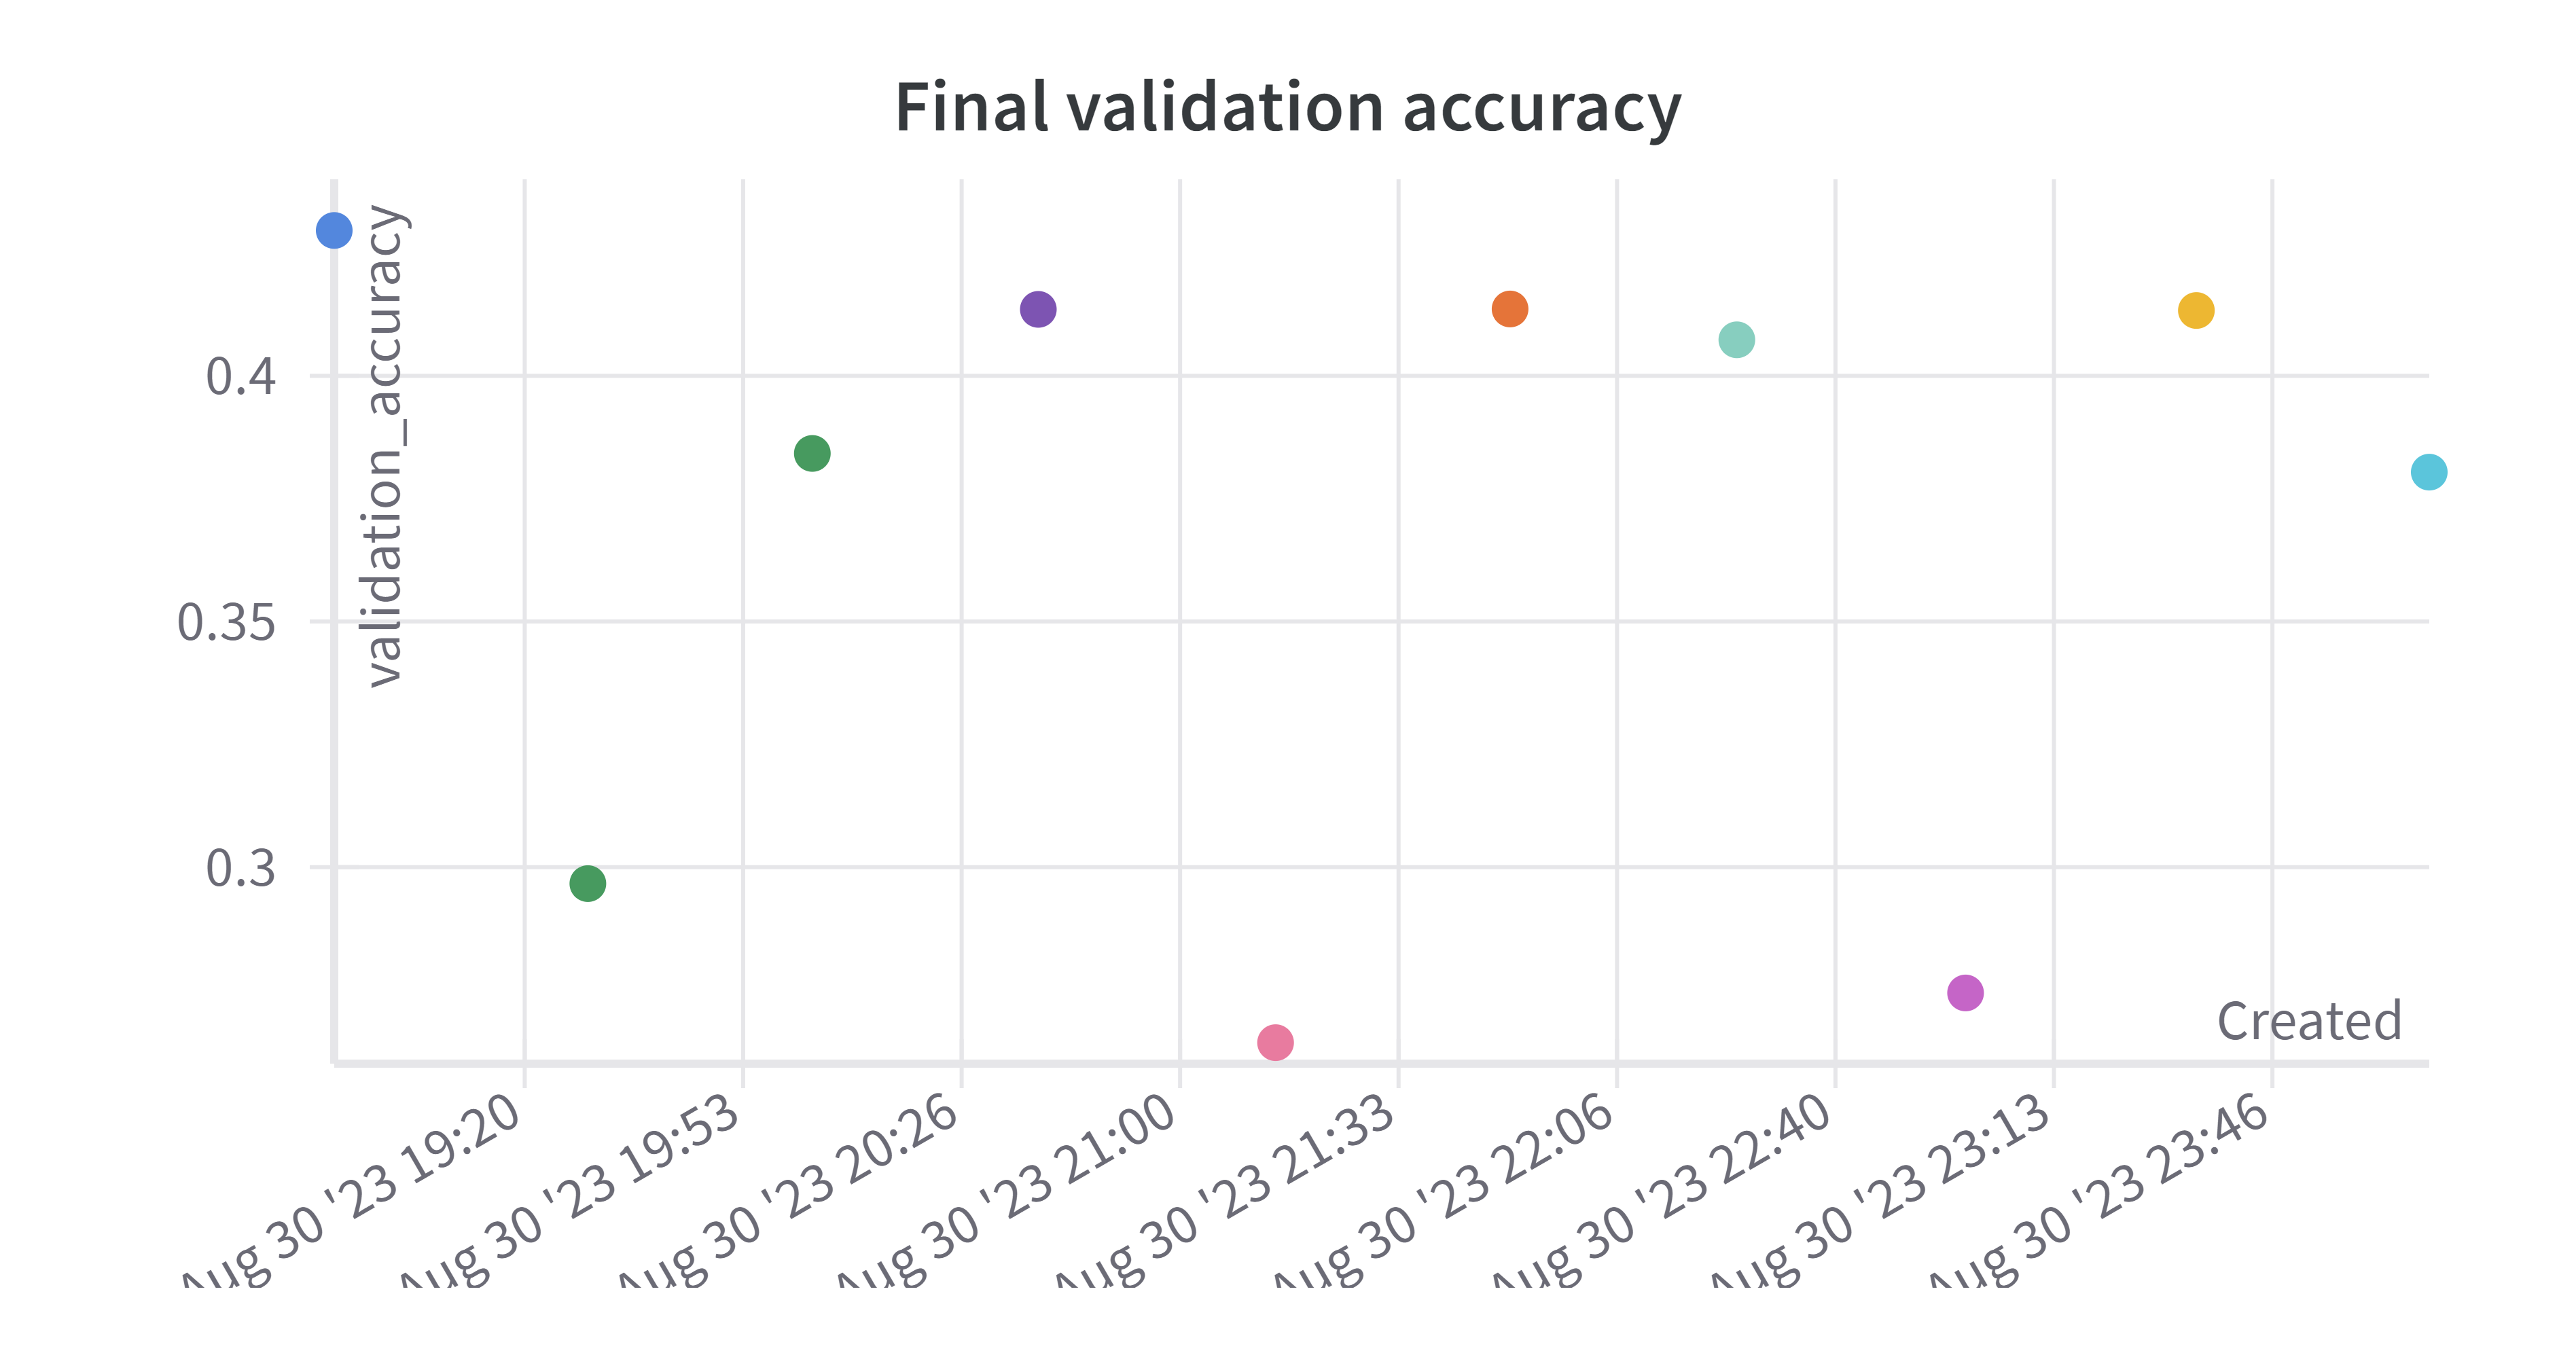
</center>

From this we can see that the runs 1, 4, 6, 7, 9 are the ones with best results.

Finally, WandB automatically computes a [parameter importance panel](https://docs.wandb.ai/guides/app/features/panels/parameter-importance), which captures relationship between hyperparameters better than the simple correlation.

<center>
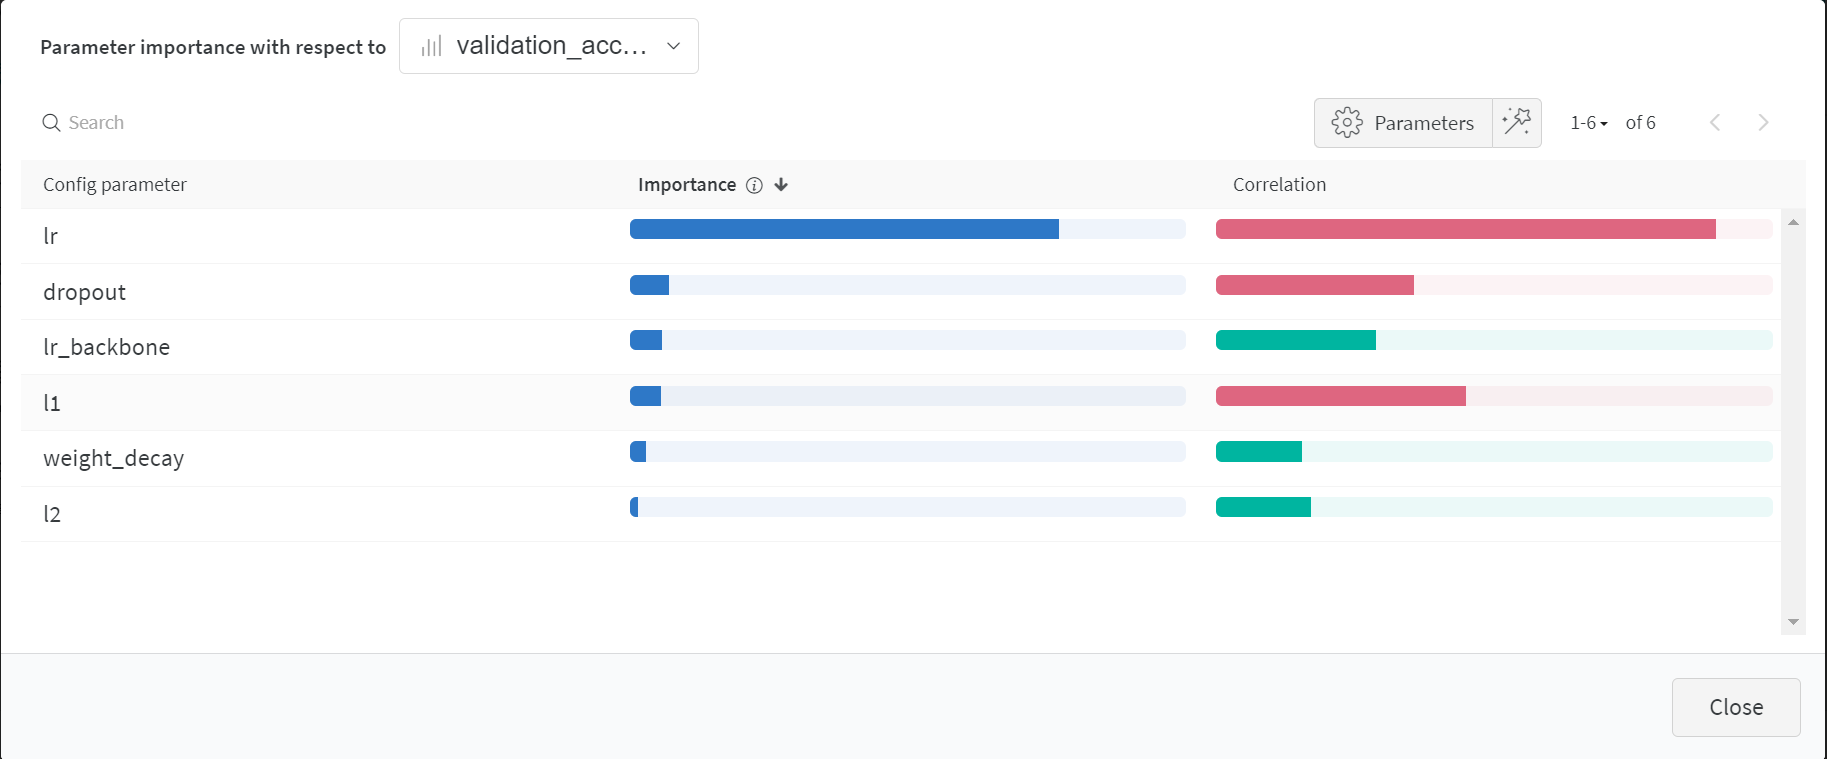
</center>

Given the sweep results, we decided not to just take the hyperparameters from the best run since the performance on 5 epochs might differ from performance on a longer training time. We thus tried to take into account all information at our disposal and selected the following values:
```
{
    "dropout": 0.3,
    "weight_decay": 1e-3
    "l1": 3.5,
    "l2": 2.5,
    "lr": 1e-4,
    "lr_backbone": 5e-5
}
```

The choice of the following hyperparameters has been taken with a similar process, looking at a sweep on a previous model with only slight differences:
```
{
    "mlp_hidden_dim": 128,
    "activation": "sigmoid",
    "batch_size": 64
}
```


## Metrics and loss
Below we describe which metrics where logged during training and used for the evaluation of the model.
- `Loss`: the loss used is a weighted sum of the smooth L1 loss and the generalized intersection over union loss.
$$ l = \lambda_1 \cdot L_{smoothL1} + \lambda_2 \cdot L_{giou} $$
<br>The Generalized Intersection over Union [Rezatiofighi, 2019](http://arxiv.org/abs/1902.09630) is an improvement over the IoU as it is different from 0 even when the bounding boxes don't overlap and thus the gradient is non-zero. It's defined as:
$$ GIoU = IoU - \frac{|C \setminus (A \cup B) |}{|C|} $$
where $C$ is the smallest convex box containing both $A$ and $B$.
- `Accuracy@N`: the accuracy at level $N$ is the percentage of predictions that have a IoU greater than $N$ with the ground truth bounding box. The accuracy at level $N$ is computed for $N \in \{0.25, 0.5, 0.75, 0.9\}$.
- `IOU`: the average IoU between the predicted bounding boxes and the ground truth bounding boxes.
- `Cosine Similarity`: cosine similarity computed on the normalized text and image features computed from CLIP [(Radford, 2021)](http://arxiv.org/abs/2103.00020). In particular, we compute the similarity between the text features and the image features obtained by cropping the image using both the predicted and the ground truth bounding boxes and then feeding them to CLIP.

In [ ]:
class Loss:
    def __init__(self, l1: float, l2: float) -> None:
        self.l1_loss = nn.SmoothL1Loss(reduction="mean")
        self.iou_loss = generalized_box_iou_loss
        self.l1: float = l1
        self.l2: float = l2
        self.loss: Tensor

    # Both bounding boxex tensors are already converted in xyxy format to use the torchvision giou function
    def compute(self, prediction: Tensor, gt_bbox: Tensor) -> Tensor:
        self.loss = self.l1 * self.l1_loss(
            gt_bbox, prediction
        ) + self.l2 * self.iou_loss(gt_bbox, prediction, reduction="mean")
        return self.loss

    def to_float(self) -> float:
        return self.loss.item()

In [ ]:
@dataclass(frozen=True)
class Metric(Enum):
    LOSS = "loss"
    ACCURACY_25 = "accuracy25"  # IoU > 0.25 -> 1 else 0
    ACCURACY_50 = "accuracy50"  # IoU > 0.5 -> 1 else 0
    ACCURACY_75 = "accuracy75"  # IoU > 0.75 -> 1 else 0
    ACCURACY_90 = "accuracy90"  # IoU > 0.9 -> 1 else 0
    IOU = "avg_iou"
    COSINE_SIMILARITY = "cosine_similarity"


@dataclass(frozen=True)
class Reduction(Enum):
    MEAN = "mean"
    SUM = "sum"
    NONE = "none"


class MetricsLogger:
    def __init__(self, metrics: Dict[str, List[float]] | None = None) -> None:
        self.metrics: Dict[str, List[float]] = {}
        if metrics is None:
            for metric in Metric:
                self.metrics[metric.value] = []
        else:
            self.metrics = metrics

    def update_metric(self, metrics: Dict[str, float]) -> None:
        for metric, value in metrics.items():
            self.metrics[metric].append(value)

    def get_metric(
        self, metric: Metric, red: Reduction = Reduction.NONE
    ) -> float | List[float]:
        values: List[float] = self.metrics[metric.value]
        match red.name:
            case Reduction.MEAN.name:
                return sum(values) / len(values)
            case Reduction.SUM.name:
                return sum(values)
            case Reduction.NONE.name:
                return values
            case _:
                raise ValueError(f"Reduction {red.name} doesn't exists")

    def __str__(self) -> str:
        res = "Metrics:\n"
        for metric, values in self.metrics.items():
            res += f"{metric}: {sum(values) / len(values)}\n"
        return res

## VG Model
  
Below is the diagram of our final model. To recap the workflow:


*   The visual encoder (modified *ResNet50*) extracts outputs of second, third and final layer
*   The text encoder (*transformer*) extracts a textual global representation and the final transformer output
*   The fusion module fuses together the multiple visual features and the textual global representation
*   The decoder (*transformer decoder*) adds fixed positional embedddings to the fusion model output and the text encoder transformed output and computes cross-attention between the two
*   The regression head (*MLP*) takes as input a learnt regression token from the decoder and extracts the bounding box in the format of (top-left corner coordinates, height, width)

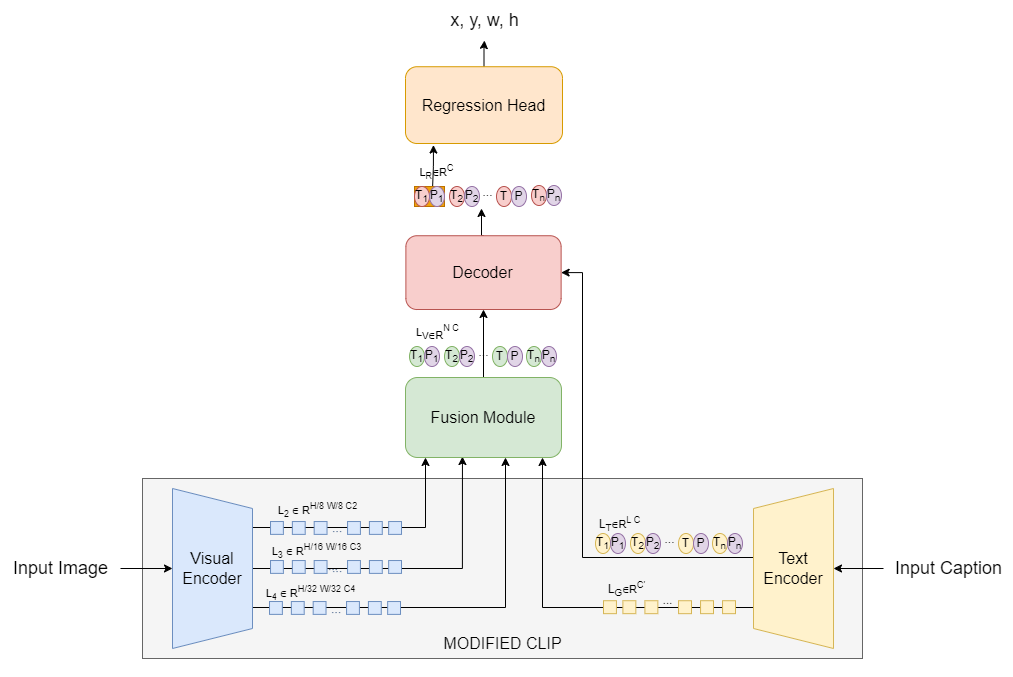

In [ ]:
class VGModel(nn.Module):
    def __init__(
        self,
        cfg: Config,
    ) -> None:
        super().__init__()
        self.cfg: Config = cfg
        embed_dim: int = cfg.model.embed_dim
        mlp_hidden_dim: int = cfg.model.mlp_hidden_dim
        dropout: float=cfg.model.dropout

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load and then build CLIP backbone
        self.clip: CLIP = torch.jit.load("../RN50.pt", map_location="cpu").eval()
        self.pretrained_model: CLIP = build_model(self.clip.state_dict()).to(
            self.device
        )
        self.pretrained_model.float()
        del self.clip

        # Freeze all clip parameters except the attention pooling layer positional embeddings
        # and the residual connection
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
        self.pretrained_model.visual.attnpool.connect.requires_grad_(True)
        self.pretrained_model.visual.attnpool.positional_embedding.requires_grad_(True)

        self.fusion_module: FusionModule = FusionModule(
            embed_dim, cfg.model.clip_embed_dim, cfg.model.proj_img_size
        ).to(self.device)

        self.decoder: Decoder = Decoder(
            embed_dim,
            cfg.model.proj_img_size,
            cfg.model.clip_ctx_length,
            cfg.model.decoder_heads,
            cfg.model.decoder_layers,
            cfg.model.decoder_dim_feedforward,
        ).to(self.device)

        activation: nn.Module = (
            nn.Sigmoid() if cfg.model.activation == "sigmoid" else nn.Softplus()
        )
        self.reg_head: MLP = MLP(
            input_dim=embed_dim,
            output_dim=4,
            hidden_dim_1=mlp_hidden_dim,
            dropout=dropout,
            act_func=activation,
        ).to(self.device)

    def forward(self, batch: List[BatchSample]) -> Tensor:
        # Get text features
        text_sequence, global_text_features = self.pretrained_model.encode_text(
            torch.stack([sample.caption for sample in batch]).squeeze(1).to(self.device)
        )

        # Get image features
        visual_features = self.pretrained_model.encode_image(
            torch.stack([sample.image for sample in batch]).to(self.device)
        )

        # Fuse features
        fused_visual_features: Tensor = self.fusion_module(
            visual_features, global_text_features
        )

        # Transformer decoder
        reg_token: Tensor = self.decoder(fused_visual_features, text_sequence)

        # Regression head
        out: Tensor = self.reg_head(reg_token)
        return out


# 2-layer MLP
class MLP(nn.Module):
    def __init__(
        self, input_dim: int, output_dim: int, hidden_dim_1: int, dropout:float, act_func: nn.Module
    ) -> None:
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.BatchNorm1d(hidden_dim_1),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, output_dim),
            act_func,
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.mlp(x)

## Training
The model has been trained for $53$ epochs using the AdamW [Loshchilov, 2019](https://arxiv.org/abs/1711.05101) optmimizer with the default 0.01 weight decay for regularization. Two different learning rates have been used, one for the backbone non-frozen parameters (i.e. residual connection and positional embeddings in the visual encoder attention pooling) and one for the rest of the model (respectively equal to $1 \times 10^{-5}$, $5 \times 10^{-5}$).

The learning rate is then decayed using the [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) scheduler with a decay rate of 0.1 and a step size of 25 (i.e. the learning rate is divided by 10 every 25 epochs).

In [ ]:
# Training utility functions


# Count trainable parameters
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Plot the grad to check for vanishing gradients by adding the function after loss.backward()
# Function taken from https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
def plot_grad_flow(named_parameters: Iterator[Tuple[str, nn.Parameter]]) -> None:
    ave_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if (p.requires_grad) and ("bias" not in n):
            if p.grad is None:
                raise RuntimeError(f"Gradient of {n} is None")
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().item())
            max_grads.append(p.grad.abs().max().item())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom=-0.001, top=0.02)  # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend(
        [
            Line2D([0], [0], color="c", lw=4),
            Line2D([0], [0], color="b", lw=4),
            Line2D([0], [0], color="k", lw=4),
        ],
        ["max-gradient", "mean-gradient", "zero-gradient"],
    )


# Compute the fraction of samples st IoU > threshold
def accuracy(iou: Tensor, threshold: float) -> Tensor:
    return torch.tensor(len(iou[iou >= threshold]) / len(iou))


# Fix the random seed for reproducibility
def init_torch(seed: int = 41) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
def train_one_epoch(
    dataloader: DataLoader[Tuple[BatchSample, Tensor]],
    model: VGModel,
    loss: Loss,
    optimizer: optim.Optimizer,
    img_size: int,
    device: device,
) -> Dict[str, float]:
    model.train()
    loss_list: List[Tensor] = []
    iou_list: List[Tensor] = []
    acc_25: List[Tensor] = []
    acc_50: List[Tensor] = []
    acc_75: List[Tensor] = []
    acc_90: List[Tensor] = []

    for idx, (batch, bbox) in enumerate(tqdm(dataloader, desc="Batches")):
        optimizer.zero_grad()
        # Move to gpu
        for sample in batch:
            sample = sample.to(device)
        bbox = bbox.to(device)

        # Forward pass
        out: Tensor = model(batch)

        # Loss and metrics
        out_xyxy = box_convert(out, in_fmt="xywh", out_fmt="xyxy")
        bbox_xyxy = box_convert(bbox, in_fmt="xywh", out_fmt="xyxy")
        batch_loss: Tensor = loss.compute(out_xyxy, bbox_xyxy)

        # Backward pass
        batch_loss.backward()
        # plot_grad_flow(model.named_parameters())

        optimizer.step()

        # Detach the tensors to avoid storing the whole computation graph in the list for each element
        out_xyxy_det: Tensor = out_xyxy.detach()
        bbox_xyxy_det: Tensor = bbox_xyxy.detach()
        batch_iou: Tensor = torch.diagonal(box_iou(out_xyxy_det, bbox_xyxy_det))

        # Log metrics
        loss_list.append(batch_loss.detach())
        iou_list.append(batch_iou.mean())
        acc_25.append(accuracy(batch_iou, 0.25))
        acc_50.append(accuracy(batch_iou, 0.5))
        acc_75.append(accuracy(batch_iou, 0.75))
        acc_90.append(accuracy(batch_iou, 0.9))

        # Log to console periodically during training to check progress
        if (idx * len(batch)) % 4096 == 0:
            report: Dict[str, float] = {
                "Train loss": batch_loss.detach().item(),
                "Train avg iou": batch_iou.mean().item(),
            }
            pprint(f"Batches: {idx}, {report}")

    return {
        Metric.LOSS.value: torch.stack(loss_list).mean().item(),
        Metric.IOU.value: torch.stack(iou_list).mean().item(),
        Metric.ACCURACY_25.value: torch.stack(acc_25).mean().item(),
        Metric.ACCURACY_50.value: torch.stack(acc_50).mean().item(),
        Metric.ACCURACY_75.value: torch.stack(acc_75).mean().item(),
        Metric.ACCURACY_90.value: torch.stack(acc_90).mean().item(),
    }


@torch.no_grad()
def validate(
    dataloader: DataLoader[Tuple[BatchSample, Tensor]],
    model: VGModel,
    loss: Loss,
    img_size: int,
    device: torch.device,
) -> Dict[str, float]:
    model.eval()
    loss_list: List[Tensor] = []
    iou_list: List[Tensor] = []
    acc_25: List[Tensor] = []
    acc_50: List[Tensor] = []
    acc_75: List[Tensor] = []
    acc_90: List[Tensor] = []

    for batch, bbox in tqdm(dataloader, desc="Batches"):
        # Move to gpu
        for sample in batch:
            sample.to(device)
        bbox = bbox.to(device)

        # Forward pass
        out: Tensor = model(batch)

        # Log metrics
        out = box_convert(out, in_fmt="xywh", out_fmt="xyxy").detach()
        bbox = box_convert(bbox, in_fmt="xywh", out_fmt="xyxy").detach()

        batch_loss: Tensor = loss.compute(out, bbox).detach()
        batch_iou: Tensor = torch.diagonal(box_iou(out, bbox)).detach()

        loss_list.append(batch_loss)
        iou_list.append(batch_iou.mean())
        acc_25.append(accuracy(batch_iou, 0.25))
        acc_50.append(accuracy(batch_iou, 0.5))
        acc_75.append(accuracy(batch_iou, 0.75))
        acc_90.append(accuracy(batch_iou, 0.9))

    return {
        Metric.LOSS.value: torch.stack(loss_list).mean().item(),
        Metric.IOU.value: torch.stack(iou_list).mean().item(),
        Metric.ACCURACY_25.value: torch.stack(acc_25).mean().item(),
        Metric.ACCURACY_50.value: torch.stack(acc_50).mean().item(),
        Metric.ACCURACY_75.value: torch.stack(acc_75).mean().item(),
        Metric.ACCURACY_90.value: torch.stack(acc_90).mean().item(),
    }

In [ ]:
def train(
    train_dataloader: DataLoader[Tuple[BatchSample, Tensor]],
    val_dataloader: DataLoader[Tuple[BatchSample, Tensor]],
    device: torch.device,
    cfg: Config,
) -> Tuple[MetricsLogger, MetricsLogger]:
    train_metrics: MetricsLogger = MetricsLogger()
    val_metrics: MetricsLogger = MetricsLogger()

    # Loss is the weighted sum of the smooth l1 loss and the GIoU
    loss_func = Loss(cfg.train.l1, cfg.train.l2)

    model: VGModel = VGModel(cfg).train()

    # Backbone parameters to train
    backbone_params: List[nn.Parameter] = [
        p for p in model.pretrained_model.parameters() if p.requires_grad
    ]

    # All parameters except the backbone parameters to train
    non_frozen_params = [
        p for p in set(model.parameters()) - set(model.pretrained_model.parameters())
    ]

    # Optimizer with different learning rates for the backbone and the rest of the model
    optimizer = optim.AdamW(
        params=[
            {"params": backbone_params, "lr": cfg.train.lr_backbone, "weight_decay": 0},
            {"params": non_frozen_params, "lr": cfg.train.lr, "weight_decay": 1e-4},
        ]
    )

    # Reduce the learning rate by a factor of 10 every 25 epochs
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg.train.step_size)

    print("Model parameters: ", count_parameters(model))

    if cfg.logging.wandb:
        wandb.watch(model, loss_func, log="all", log_freq=100, log_graph=True)

    for epoch in tqdm(range(cfg.epochs), desc="Epochs"):
        print("-------------------- Training --------------------------")

        # Train for one epoch
        epoch_train_metrics: Dict[str, float] = train_one_epoch(
            dataloader=train_dataloader,
            model=model,
            loss=loss_func,
            optimizer=optimizer,
            img_size=cfg.model.img_size,
            device=device,
        )

        lr_scheduler.step()

        train_metrics.update_metric(epoch_train_metrics)
        print("Training metrics at epoch ", epoch)
        print(epoch_train_metrics)

        # Evaluate on validation set for hyperparameter tuning and logging
        print("-------------------- Validation ------------------------")
        epoch_val_metrics: Dict[str, float] = validate(
            dataloader=val_dataloader,
            model=model,
            loss=loss_func,
            img_size=cfg.model.img_size,
            device=device,
        )
        val_metrics.update_metric(epoch_val_metrics)
        print("Validation metrics at epoch ", epoch)
        print(epoch_val_metrics)

        # Log metric to wandb for hyperparameter tuning
        if cfg.train.sweep:
            wandb.log(
                {
                    "validation_accuracy": epoch_val_metrics[Metric.IOU.value],
                }
            )

        # Log metrics to wandb putting train and val metrics together
        if cfg.logging.wandb:
            wandb.log(
                {
                    "Loss": {
                        "train": epoch_train_metrics[Metric.LOSS.value],
                        "val": epoch_val_metrics[Metric.LOSS.value],
                    },
                    "Average IOU": {
                        "train": epoch_train_metrics[Metric.IOU.value],
                        "val": epoch_val_metrics[Metric.IOU.value],
                    },
                    "Accuracy@25": {
                        "train": epoch_train_metrics[Metric.ACCURACY_25.value],
                        "val": epoch_val_metrics[Metric.ACCURACY_25.value],
                    },
                    "Accuracy@50": {
                        "train": epoch_train_metrics[Metric.ACCURACY_50.value],
                        "val": epoch_val_metrics[Metric.ACCURACY_50.value],
                    },
                    "Accuracy@75": {
                        "train": epoch_train_metrics[Metric.ACCURACY_75.value],
                        "val": epoch_val_metrics[Metric.ACCURACY_75.value],
                    },
                    "Accuracy@90": {
                        "train": epoch_train_metrics[Metric.ACCURACY_90.value],
                        "val": epoch_val_metrics[Metric.ACCURACY_90.value],
                    },
                },
                commit=True,
            )

        # Save model after each epoch so that we can resume training or take the best model
        if cfg.logging.save:
            dir: str = cfg.logging.path
            if not os.path.exists(dir):
                os.makedirs(dir)
            torch.save(
                obj={
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "lr_scheduler_state_dict": lr_scheduler.state_dict(),
                    "loss": epoch_train_metrics[Metric.LOSS.value],
                },
                f=f"{dir}model{epoch}.pth",
            )

        # Free memory
        torch.cuda.empty_cache()
        gc.collect()

    return train_metrics, val_metrics

In [ ]:
# Load configuration, create datasets, dataloaders and train the model
def initialize_run(sweep: bool = True) -> None:
    config = Config()
    if sweep:
        wandb.login(key=os.getenv("WANDB_API_KEY"))
        wandb.init(project="vgproject")

        # Set the training configurations we are tuning equal to the sweep run configurations
        wandb_cfg = wandb.config
        config.update(wandb_cfg)
    else:
        if config.logging.wandb:
            wandb.login(key=os.getenv("WANDB_API_KEY"))
            wandb.init(project="vgproject", config=config.as_dict())

    train_dataset: VGDataset = VGDataset(
        dir_path=config.dataset_path,
        split=Split.TRAIN,
        output_bbox_type=BboxType.XYWH,
        transform=True,
        augment=True,
        preprocessed=True,
    )
    print("Train dataset created. Dataset length ", len(train_dataset))

    # Validation dataset is not augmented to be more similar to the test set
    val_dataset: VGDataset = VGDataset(
        dir_path=config.dataset_path,
        split=Split.VAL,
        output_bbox_type=BboxType.XYWH,
        transform=True,
        augment=False,
        preprocessed=True,
    )
    print("Validation dataset created. Dataset length: ", len(val_dataset))

    train_dataloader: DataLoader[Tuple[BatchSample, Tensor]] = DataLoader(
        dataset=train_dataset,
        batch_size=config.train.batch_size,
        collate_fn=custom_collate,
        num_workers=2,
        shuffle=True,
        drop_last=True,
    )

    val_dataloader: DataLoader[Tuple[BatchSample, Tensor]] = DataLoader(
        dataset=val_dataset,
        batch_size=config.train.batch_size,
        collate_fn=custom_collate,
        shuffle=True,
        drop_last=True,
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_metrics, val_metrics = train(train_dataloader, val_dataloader, device, config)

    json.dump(train_metrics.metrics, open("../train_metrics.json", "w"))
    json.dump(val_metrics.metrics, open("../val_metrics.json", "w"))

    if config.logging.wandb:
        wandb.finish()

In [ ]:
def main() -> None:
    init_torch()
    cfg = Config()
    if cfg.train.sweep:
        sweep_configuration: Dict[str, Any] = json.load(
            open("../sweep_config.json", "r")
        )
        sweep: str = wandb.sweep(sweep_configuration, project="vgproject")
        wandb.agent(sweep, function=initialize_run, count=10)
    else:
        initialize_run(cfg.train.sweep)

In [ ]:
# Start training
main()

In [ ]:
# Used for cleaning up the environment
wandb.finish()
torch.cuda.empty_cache()
gc.collect()

### Training analysis
Here we show the plots for *loss* (training and validation) and *average IOU* (training and validation), which we use as a measure of the localization accuracy of our model.  
  
From the plots we can see that in the fisrt 5/10 epochs the validation loss is lower than the training loss, while the validation accuracy is higher than the training accuracy. This behaviour can be explained by the dropout being active when computing training metrics but not being active when computing validation metrics.<br>
Afterwards, the model improves slowly until the validation IOU hits a plateau towards the final epochs, while the training IOU keeps on partially improving. Correspondingly, the validation loss hits a plateau while the training loss keeps on slowly decreasing. A similar behaviour might be a sign of either overfitting or getting stuck in a local minimum for the loss.

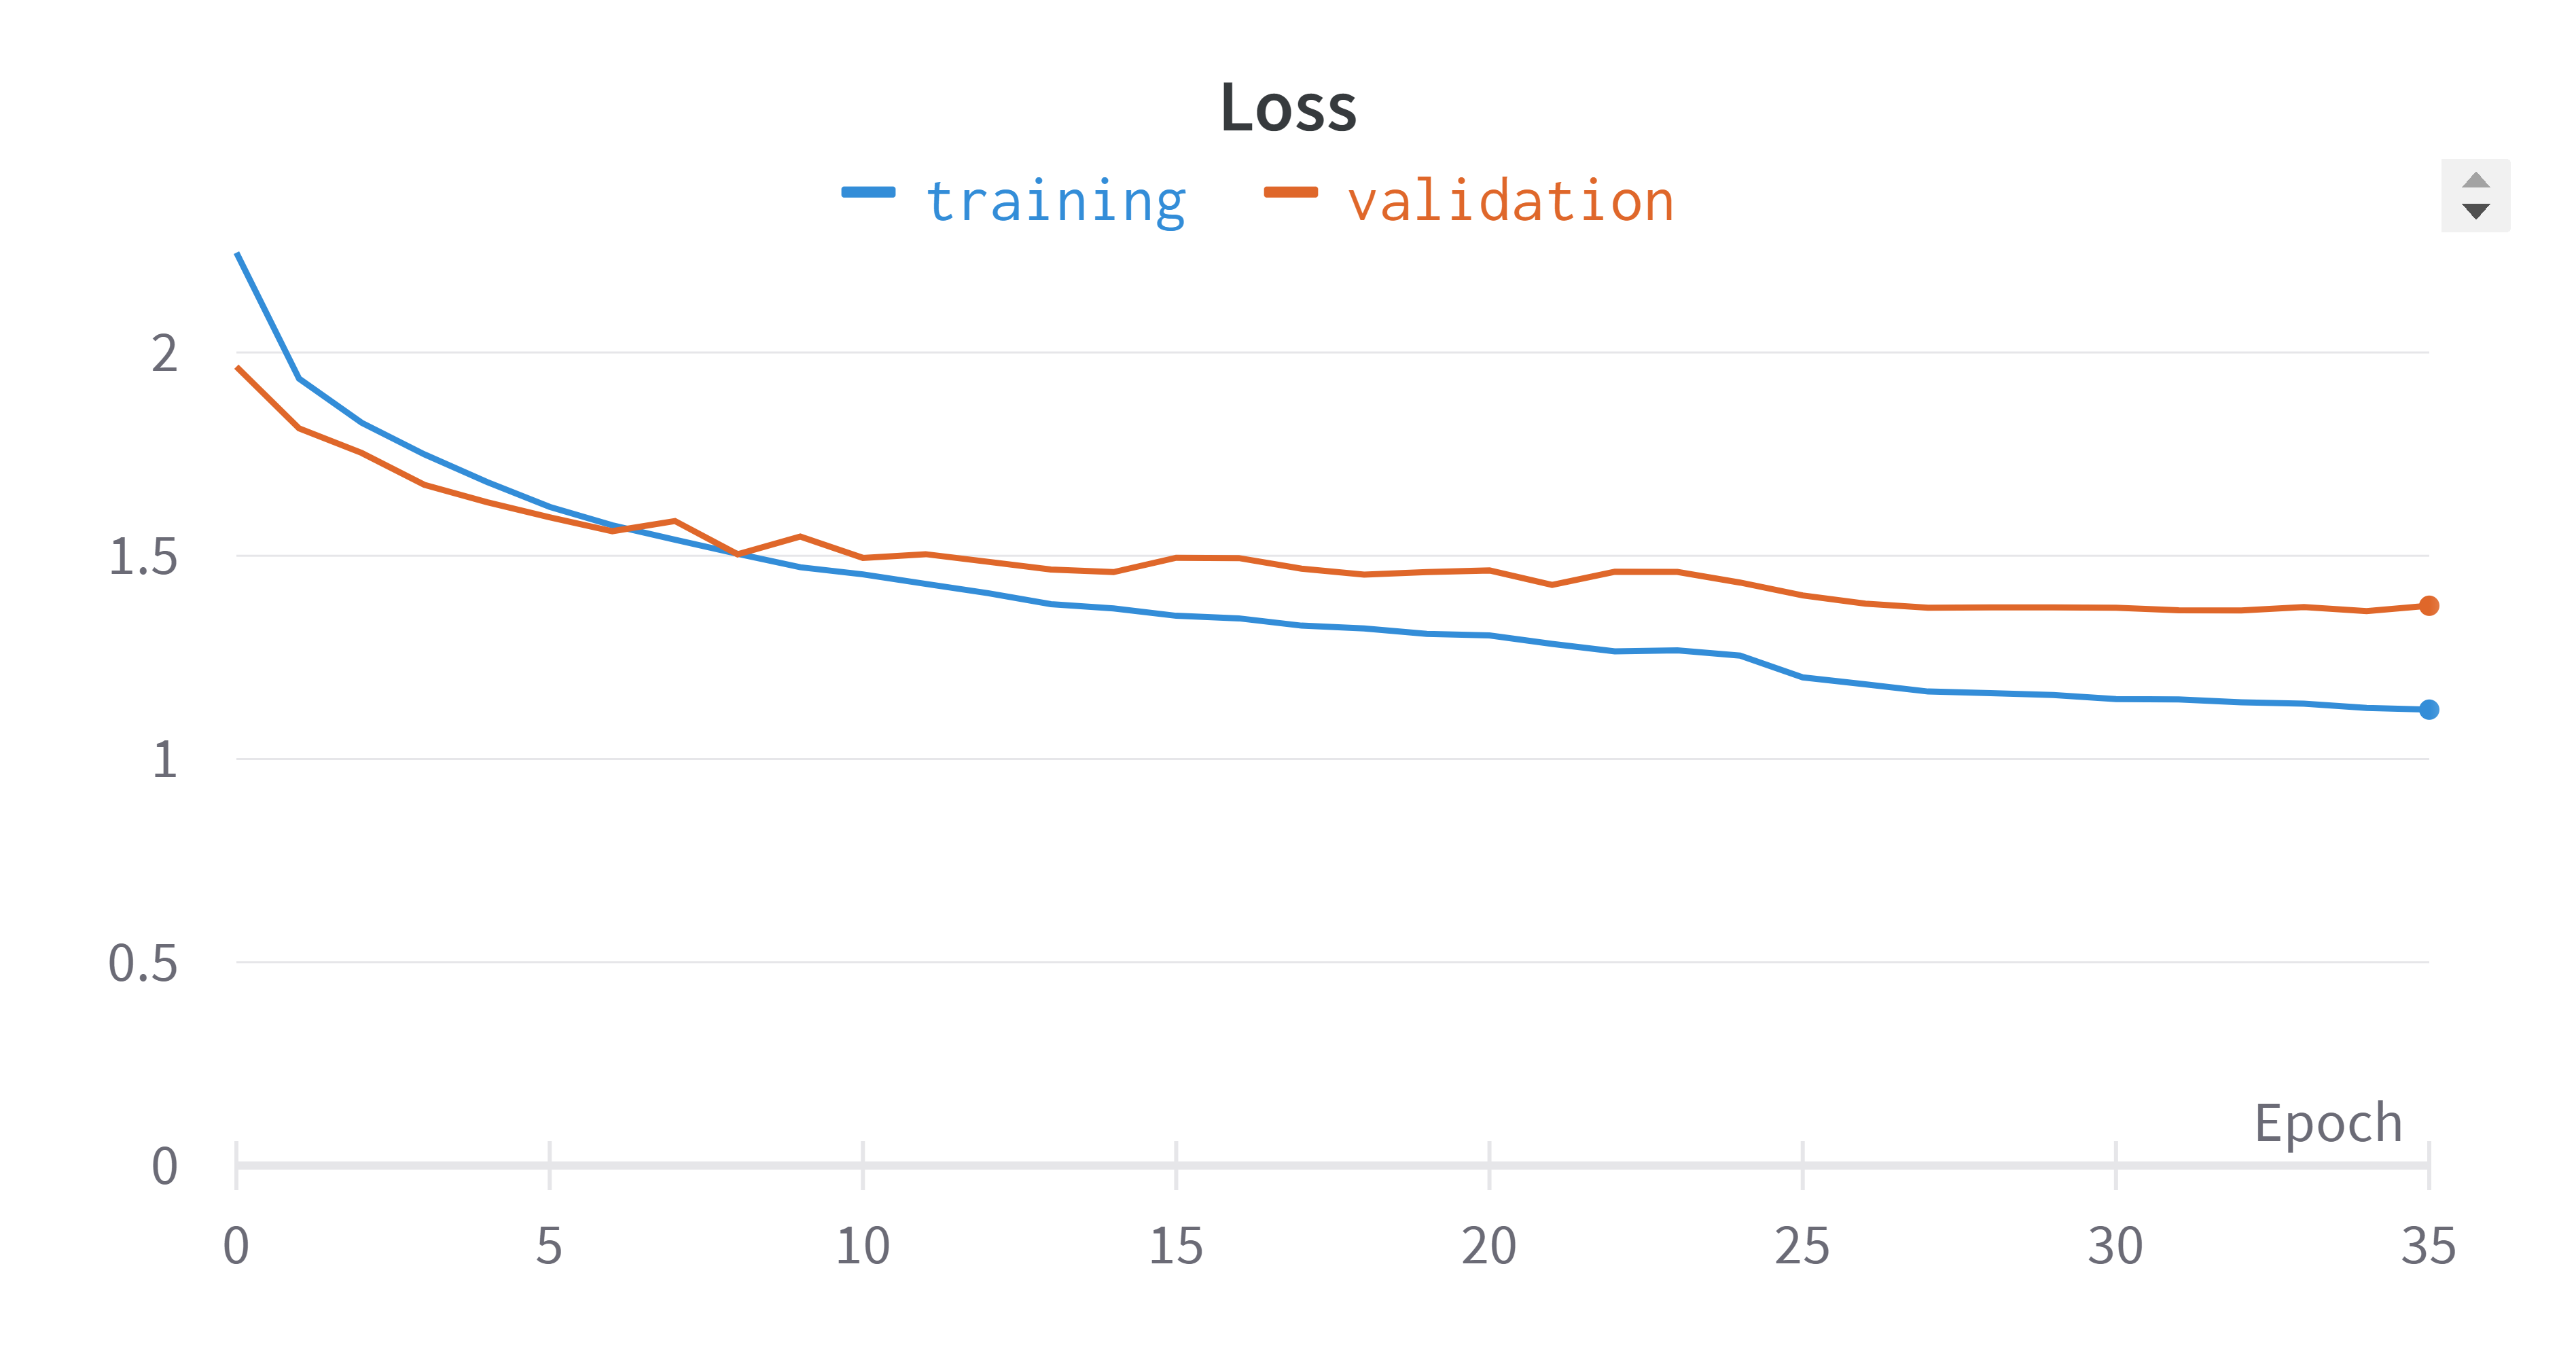
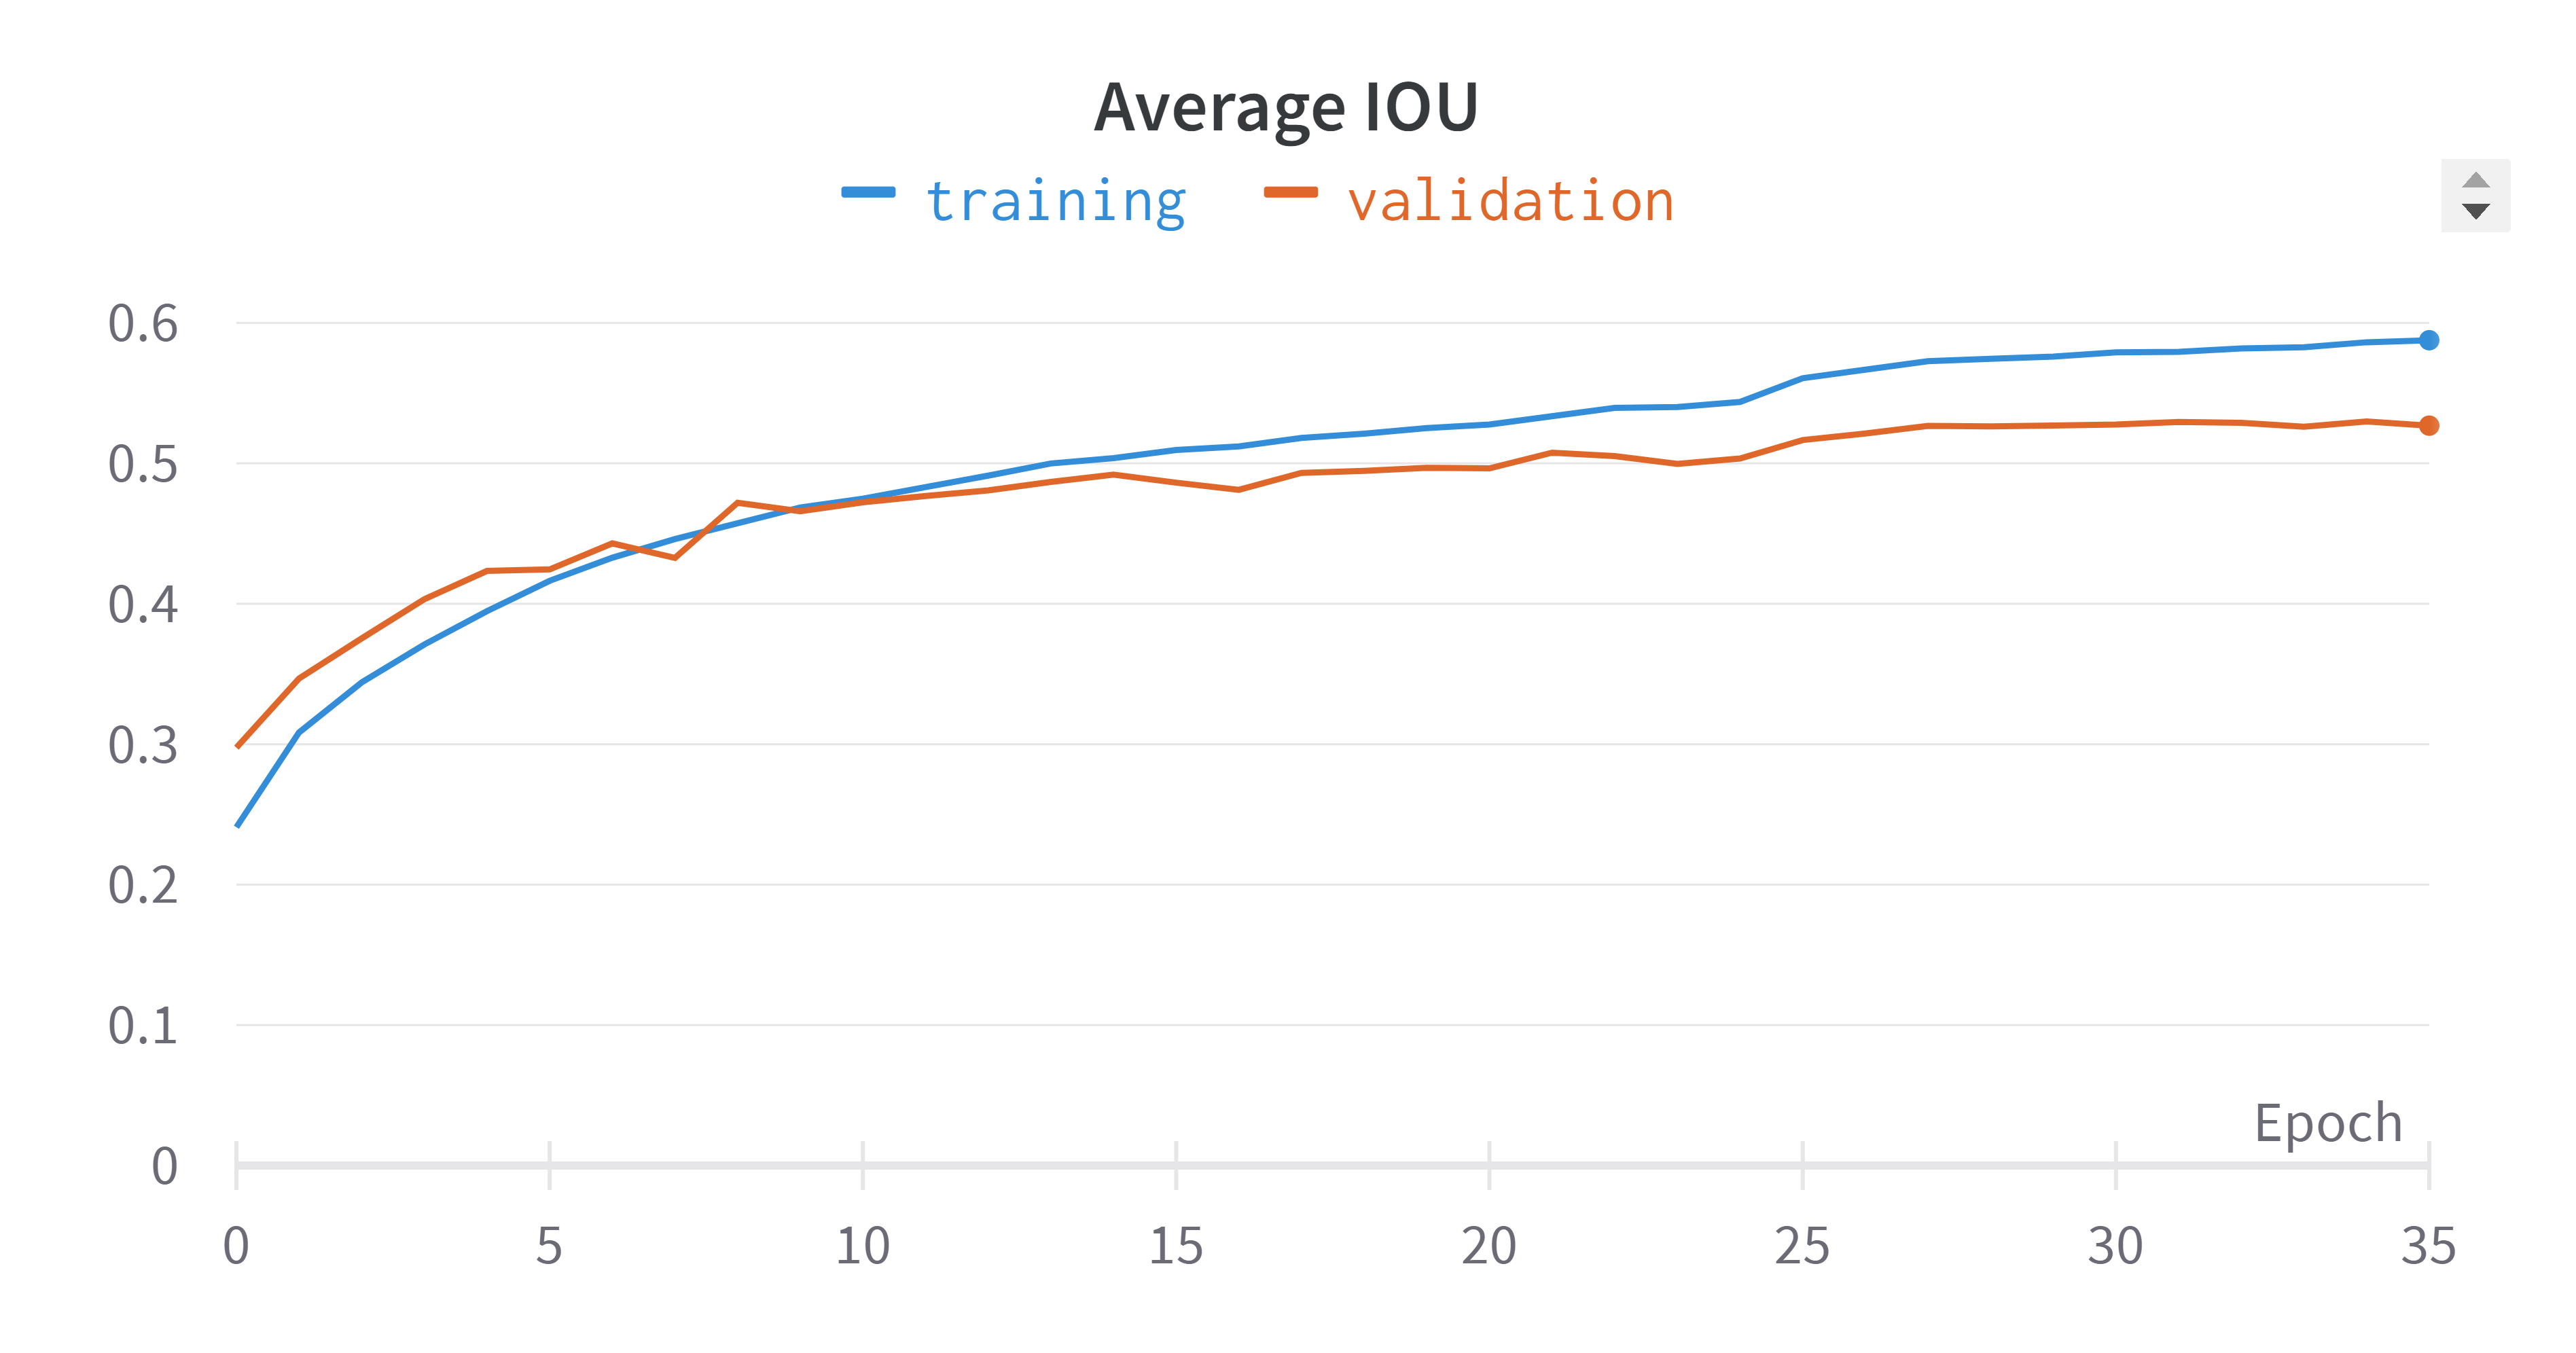

Here we show a plot with the *accuracy@N* metrics (traing and validation), where $N ∈ \{0.25,0.50,0.75,0.90\}$.

TODO: comment

<center>
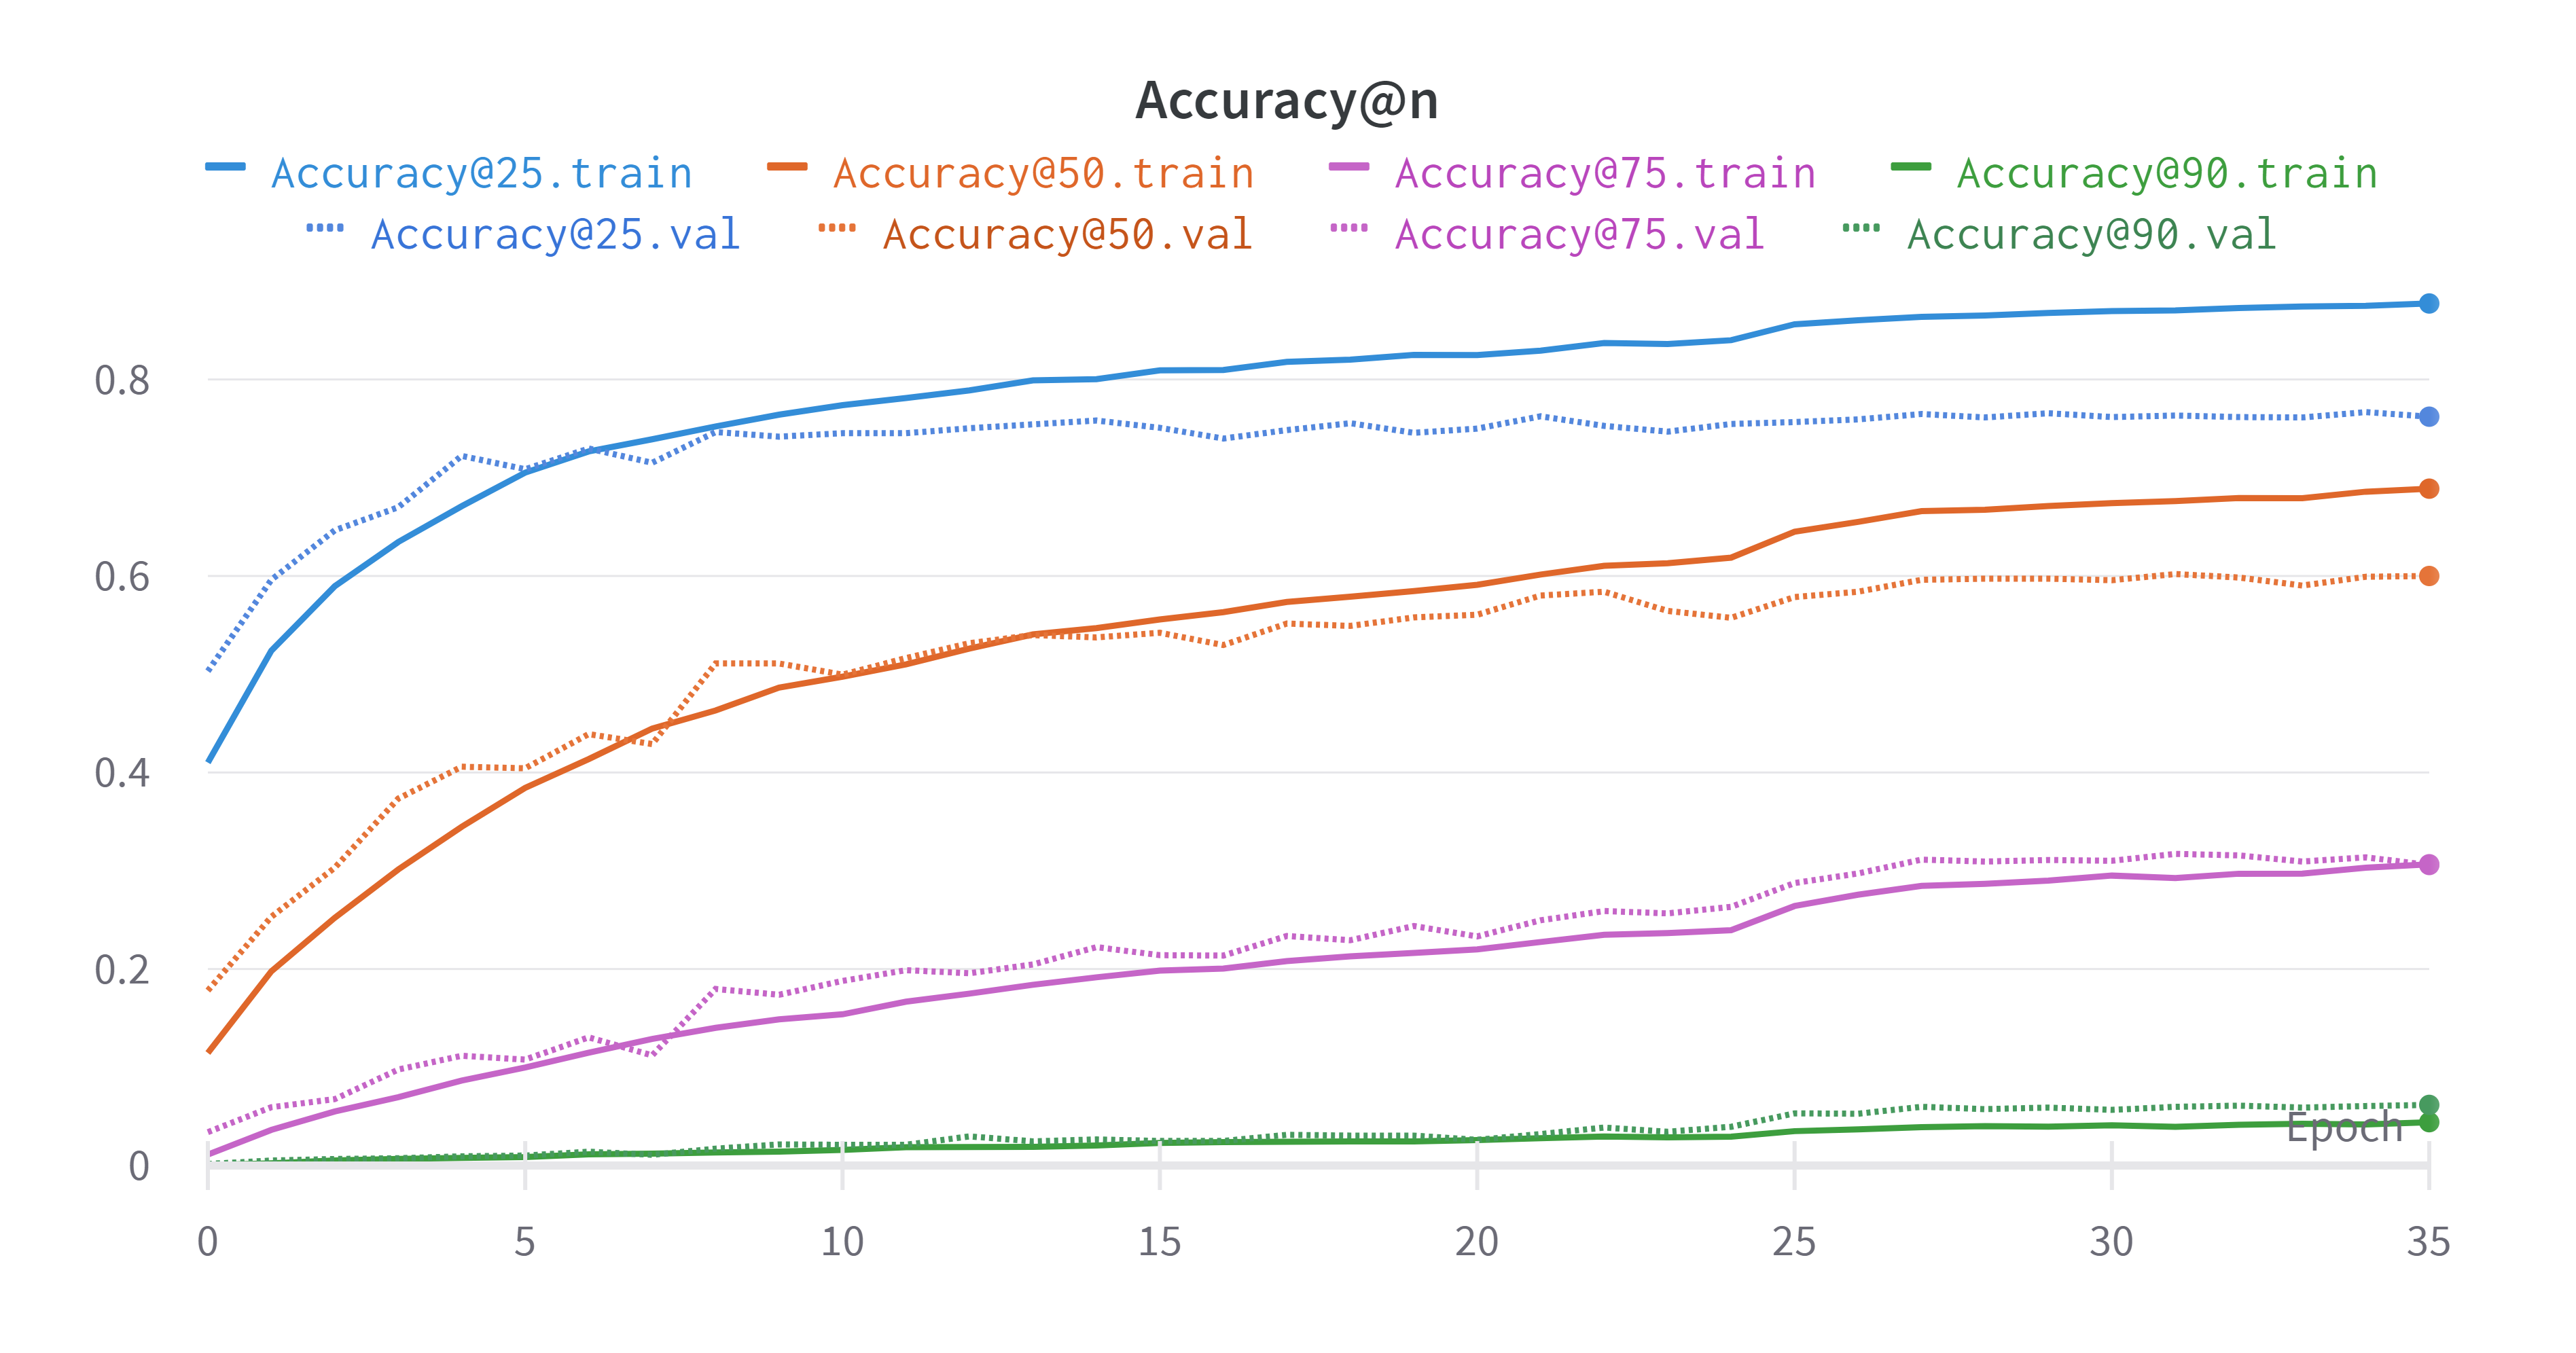
</center>

## Evaluation

### Baseline Evaluation

In [ ]:
clip_model, _ = clip.load("RN50")


def compute_cosine_similarity(
    image_features: Tensor, text_features: Tensor, transform_func: T.Compose | None
) -> Tensor:
    if transform_func is not None:
        image_features = clip_model.encode_image(transform_func(image_features))
    else:
        image_features = clip_model.encode_image(image_features)
    text_features = clip_model.encode_text(text_features.squeeze_(1))

    image_norm = image_features / image_features.norm(dim=-1, keepdim=True)
    text_norm = text_features / text_features.norm(dim=-1, keepdim=True)
    return (
        torch.nn.functional.cosine_similarity(image_norm, text_norm, dim=-1)
        .detach()
        .squeeze(0)
    )

In [ ]:
@torch.no_grad()
def eval_baseline() -> None:
    cfg = Config()
    test_data = VGDataset(
        dir_path=cfg.dataset_path,
        split=Split.TEST,
        output_bbox_type=BboxType.XYXY,
        transform=False,
        augment=False,
        preprocessed=True,
    )

    dataloader: DataLoader[Any] = DataLoader(
        test_data,
        batch_size=1,
        shuffle=False,
        collate_fn=custom_collate,
        drop_last=True,
    )

    baseline = Baseline()

    iou_list: List[Tensor] = []
    acc_25: List[Tensor] = []
    acc_50: List[Tensor] = []
    acc_75: List[Tensor] = []
    acc_90: List[Tensor] = []
    cos_sim_pred: List[Tensor] = []
    cos_sim_gt: List[Tensor] = []

    # Same transformations as the ones in the CLIP preprocessor
    transformation = T.Compose(
        [
            T.Resize(cfg.model.img_size),
            T.CenterCrop(cfg.model.img_size),
            lambda x: x / 255.0,
            lambda x: x.repeat(1, 3, 1, 1) if x.shape[1] == 1 else x,
            T.Normalize(
                (0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )
    for idx, (batch, bboxes) in enumerate(tqdm(dataloader, desc="Batches")):
        for sample in batch:
            sample = sample.to(baseline.device)
        bboxes = bboxes.to(baseline.device)

        prediction: List[Result] = baseline.predict(batch)
        bbox_pred: Tensor = torch.stack([p.bounding_box for p in prediction]).to(
            baseline.device
        )
        bbox_gt: Tensor = bboxes.clone().detach().squeeze(1).to(baseline.device)

        box_gt_xyxy = box_convert(bbox_gt, in_fmt="xywh", out_fmt="xyxy")
        box_pred_xywh = box_convert(bbox_pred, in_fmt="xyxy", out_fmt="xywh")

        batch_iou: Tensor = torch.diagonal(box_iou(box_gt_xyxy, bbox_pred))

        iou_list.append(batch_iou.mean())
        acc_25.append(accuracy(batch_iou, 0.25))
        acc_50.append(accuracy(batch_iou, 0.5))
        acc_75.append(accuracy(batch_iou, 0.75))
        acc_90.append(accuracy(batch_iou, 0.9))

        image_features_gt = torch.stack(
            [
                FT.crop(
                    sample.image,
                    int(bbox[1].item()),
                    int(bbox[0].item()),
                    int(bbox[3].item()),
                    int(bbox[2].item()),
                )
                for sample, bbox in zip(batch, bbox_gt)
            ]
        ).to(baseline.device)

        image_features_pred = torch.stack(
            [
                FT.crop(
                    sample.image,
                    int(bbox[1].item()),
                    int(bbox[0].item()),
                    int(bbox[3].item()),
                    int(bbox[2].item()),
                )
                for sample, bbox in zip(batch, box_pred_xywh)
            ]
        ).to(baseline.device)

        text_features = torch.stack([sample.caption for sample in batch]).to(
            baseline.device
        )
        cos_sim_pred.append(
            compute_cosine_similarity(
                image_features_pred, text_features, transformation
            )
        )
        cos_sim_gt.append(
            compute_cosine_similarity(image_features_gt, text_features, transformation)
        )

    json.dump(
        {
            Metric.IOU.value: torch.stack(iou_list).cpu().numpy().tolist(),
            Metric.ACCURACY_25.value: torch.stack(acc_25).cpu().numpy().tolist(),
            Metric.ACCURACY_50.value: torch.stack(acc_50).cpu().numpy().tolist(),
            Metric.ACCURACY_75.value: torch.stack(acc_75).cpu().numpy().tolist(),
            Metric.ACCURACY_90.value: torch.stack(acc_90).cpu().numpy().tolist(),
            Metric.COSINE_SIMILARITY.value
            + " prediction": torch.stack(cos_sim_pred).cpu().numpy().tolist(),
            Metric.COSINE_SIMILARITY.value
            + " ground truth": torch.stack(cos_sim_gt).cpu().numpy().tolist(),
        },
        open("../test_metrics_baseline.json", "w"),
    )

    pprint(
        object={
            Metric.IOU.value: torch.stack(iou_list).mean().item(),
            Metric.ACCURACY_25.value: torch.stack(acc_25).mean().item(),
            Metric.ACCURACY_50.value: torch.stack(acc_50).mean().item(),
            Metric.ACCURACY_75.value: torch.stack(acc_75).mean().item(),
            Metric.ACCURACY_90.value: torch.stack(acc_90).mean().item(),
            Metric.COSINE_SIMILARITY.value
            + " prediction": torch.stack(cos_sim_pred).mean().item(),
            Metric.COSINE_SIMILARITY.value
            + " ground truth": torch.stack(cos_sim_gt).mean().item(),
        }
    )

In [ ]:
eval_baseline()

In [ ]:
# Download the evaluation statistics for the baseline and load them into a dataframe
url = "https://drive.google.com/uc?export=download&id=1uKJE18SmCLEva-qP4e7LjD_dnbs2DLX8"
gdown.download(
    url=url, output="../test_metrics_baseline.json", quiet=False, resume=True
)

df = pd.read_json("../test_metrics_baseline.json")
df.mean()

### Model Evaluation

In [ ]:
@torch.no_grad()
def eval(model_file: str) -> None:
    cfg = Config()
    dataset = VGDataset(
        dir_path=cfg.dataset_path,
        split=Split.TEST,
        output_bbox_type=BboxType.XYXY,
        transform=True,
        augment=False,
        preprocessed=True,
    )

    dataloader: DataLoader[Tuple[BatchSample, Tensor]] = DataLoader(
        dataset=dataset,
        batch_size=1,
        collate_fn=custom_collate,
        shuffle=False,
        drop_last=False,
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint: Dict[str, Any] = torch.load(
        f"../runs/{model_file}", map_location=device
    )
    model: VGModel = VGModel(cfg)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()

    loss = Loss(cfg.train.l1, cfg.train.l2)
    loss_list: List[Tensor] = []
    iou_list: List[Tensor] = []
    acc_25: List[Tensor] = []
    acc_50: List[Tensor] = []
    acc_75: List[Tensor] = []
    acc_90: List[Tensor] = []
    cos_sim_img: List[Tensor] = []
    cos_sim_pred: List[Tensor] = []
    cos_sim_gt: List[Tensor] = []

    transformation = T.Compose(
        [
            T.Resize(cfg.model.img_size),
            T.CenterCrop(cfg.model.img_size),
        ]
    )

    for idx, (batch, bbox) in enumerate(tqdm(dataloader, desc="Batches")):
        # Move to gpu
        for sample in batch:
            sample = sample.to(device)
        bboxes: Tensor = bbox.to(device)

        # Forward pass
        out: Tensor = model(batch)

        # Loss and metrics
        out_xyxy: Tensor = box_convert(
            out * cfg.model.img_size, in_fmt="xywh", out_fmt="xyxy"
        )

        # Check if the box overflow image
        for sample, bbox in zip(batch, out_xyxy):
            if (
                0 > bbox[0]
                or bbox[0] > sample.image.shape[2]
                or 0 > bbox[2]
                or bbox[2] > sample.image.shape[2]
                or 0 > bbox[1]
                or bbox[1] > sample.image.shape[1]
                or 0 > bbox[3]
                or bbox[3] > sample.image.shape[1]
            ):
                bbox = clip_boxes_to_image(bbox, (cfg.model.img_size, cfg.model.img_size))


        bbox_xyxy: Tensor = box_convert(
            bboxes * cfg.model.img_size, in_fmt="xywh", out_fmt="xyxy"
        )
        batch_loss: Tensor = loss.compute(out_xyxy, bbox_xyxy)

        out_xyxy_det: Tensor = out_xyxy.detach()
        bbox_xyxy_det: Tensor = bbox_xyxy.detach()
        batch_iou: Tensor = torch.diagonal(box_iou(out_xyxy_det, bbox_xyxy_det))

        loss_list.append(batch_loss.detach())
        iou_list.append(batch_iou.mean())

        acc_25.append(accuracy(batch_iou, 0.25))
        acc_50.append(accuracy(batch_iou, 0.5))
        acc_75.append(accuracy(batch_iou, 0.75))
        acc_90.append(accuracy(batch_iou, 0.9))

        image_features_gt = torch.stack(
            [
                FT.crop(
                    sample.image,
                    int(bbox[1].item()),
                    int(bbox[0].item()),
                    int(bbox[3].item()),
                    int(bbox[2].item()),
                )
                for sample, bbox in zip(batch, bboxes * cfg.model.img_size)
            ]
        ).to(device)
        image_features_pred = torch.stack(
            [
                FT.crop(
                    sample.image,
                    int(bbox[1].item()),
                    int(bbox[0].item()),
                    int(bbox[3].item()),
                    int(bbox[2].item()),
                )
                for sample, bbox in zip(batch, out * cfg.model.img_size)
            ]
        ).to(device)
        text_features = torch.stack([sample.caption for sample in batch]).to(device)
        cos_sim_pred.append(
            compute_cosine_similarity(
                image_features_pred, text_features, transformation
            )
        )
        cos_sim_gt.append(
            compute_cosine_similarity(image_features_gt, text_features, transformation)
        )
        cos_sim_img.append(
            compute_cosine_similarity(
                torch.stack([sample.image for sample in batch]).to(device),
                text_features,
                None,
            )
        )

    json.dump(
        {
            Metric.LOSS.value: torch.stack(loss_list).cpu().numpy().tolist(),
            Metric.IOU.value: torch.stack(iou_list).cpu().numpy().tolist(),
            Metric.ACCURACY_25.value: torch.stack(acc_25).cpu().numpy().tolist(),
            Metric.ACCURACY_50.value: torch.stack(acc_50).cpu().numpy().tolist(),
            Metric.ACCURACY_75.value: torch.stack(acc_75).cpu().numpy().tolist(),
            Metric.ACCURACY_90.value: torch.stack(acc_90).cpu().numpy().tolist(),
            Metric.COSINE_SIMILARITY.value
            + " prediction": torch.stack(cos_sim_pred).cpu().numpy().tolist(),
            Metric.COSINE_SIMILARITY.value
            + " ground truth": torch.stack(cos_sim_gt).cpu().numpy().tolist(),
            Metric.COSINE_SIMILARITY.value
            + " image": torch.stack(cos_sim_img).cpu().numpy().tolist(),
        },
        open("../test_metrics.json", "w"),
    )

    pprint(
        object={
            Metric.LOSS.value: torch.stack(loss_list).mean().item(),
            Metric.IOU.value: torch.stack(iou_list).mean().item(),
            Metric.ACCURACY_25.value: torch.stack(acc_25).mean().item(),
            Metric.ACCURACY_50.value: torch.stack(acc_50).mean().item(),
            Metric.ACCURACY_75.value: torch.stack(acc_75).mean().item(),
            Metric.ACCURACY_90.value: torch.stack(acc_90).mean().item(),
            Metric.COSINE_SIMILARITY.value
            + " prediction": torch.stack(cos_sim_pred).mean().item(),
            Metric.COSINE_SIMILARITY.value
            + " ground truth": torch.stack(cos_sim_gt).mean().item(),
            Metric.COSINE_SIMILARITY.value
            + " image": torch.stack(cos_sim_img).mean().item(),
        }
    )

In [ ]:
# Download the model best checkpoint from the drive
if not os.path.exists("runs/model35.pth"):
    print("Downloading model...")
    url = "https://drive.google.com/uc?export=download&id=1Zw-Pwv9b_M6YLcQeSazYctlXUZ4ovqK7"
    gdown.download(url=url, output="../runs/model35.pth", quiet=False, resume=True)

In [ ]:
eval("model35.pth")

In [ ]:
# Download the evaluation statistics and load them into a dataframe
url = "https://drive.google.com/uc?export=download&id=1Ug7jubc02Iwwhl4_uUmG-yRCBk94g8sj"
gdown.download(url=url, output="../test_metrics.json", quiet=False, resume=True)

df = pd.read_json("../test_metrics.json")
df.mean()

### Evaluation analysis

We show here a comparison of the test metrics for the baseline and our model.

<center>

<!-- -->            	|  IoU  | Accuracy@25 	| Accuracy@50 	| Accuracy@75 	| Accuracy@90 	| Similarity <br> Ground Truth 	| Similarity <br> Prediction
:--------------	|:----:	|:-----------:	|:-----------:	|:-----------:	|:-----------:	|:-------------:	            |:---------------:
**Baseline** 	| 0.53 	|     0.63    	|     0.54    	|     0.47    	|     0.35    	|      0.24     	            |       0.23
**VGModel** 	| 0.53  |     0.76      |     0.60      |     0.31      |     0.06      |      0.20     	            |       0.20

</center>

As we can see, the average accuracy for the two models is similar. However, our model has better performances for the accuracy at 25 and 50, while the baseline has better performances for the accuracy at 75 and 90. This is to be expected as the baseline uses a pretrained object detector and thus the predictions tend to be extremely precise (i.e. the detected object is the same described in the referring expression) or extremely wrong (i.e. the detected object is not the one described in the caption), while the VGModel predicts the bounding box without any prior knowledge of the objects in the image.

Concerning cosine similarity between the caption and the bounding box, we can see that in our model it is lower than in the baseline. This means that our model doesn't align semantic representations between image and text as well. A similar behaviour can be expected for the predicted bounding box, since in the baseline it is chosen with the goal of maximising exactly this value while our model does not take it into account in any way. As for the difference in cosine similarity for the ground truth, the difference between the two models is probably due to the fact that our model resizes images in order to be compatible with CLIP while the baseline does not and thus doesn't lose information due to the change in aspect ratio.

## Conclusions

Ipotesi sul perchè performa come performa, idee per lavori futuri

## References

Deng, J., Yang, Z., Chen, T., Zhou, W., & Li, H. (2022). *TransVG: End-to-End Visual Grounding with Transformers.* http://arxiv.org/abs/2104.08541

Jiang, H., Lin, Y., Han, D., Song, S., & Huang, G. (2022). *Pseudo-Q: Generating Pseudo Language Queries for Visual Grounding.* http://arxiv.org/abs/2203.08481


Liu, L., Liu, X., Gao, J., Chen, W., & Han, J. (2020). *Understanding the Difficulty of Training Transformers.* http://arxiv.org/abs/2004.08249

Liu, R., Lehman, J., Molino, P., Such, F. P., Frank, E., Sergeev, A., & Yosinski, J. (2018). *An Intriguing Failing of Convolutional Neural Networks and the CoordConv Solution.* http://arxiv.org/abs/1807.03247

Loshchilov, I., & Hutter, F. (2019). *Decoupled Weight Decay Regularization.* http://arxiv.org/abs/1711.05101

Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., … Sutskever, I. (2021). *Learning Transferable Visual Models From Natural Language Supervision.* http://arxiv.org/abs/2103.00020

Rezatofighi, H., Tsoi, N., Gwak, J., Sadeghian, A., Reid, I., & Savarese, S. (2019). *Generalized Intersection over Union: A Metric and A Loss for Bounding Box Regression.* http://arxiv.org/abs/1902.09630

Subramanian, S., Merrill, W., Darrell, T., Gardner, M., Singh, S., & Rohrbach, A. (2022). *ReCLIP: A Strong Zero-Shot Baseline for Referring Expression Comprehension.* http://arxiv.org/abs/2204.05991

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2023). *Attention Is All You Need.* http://arxiv.org/abs/1706.03762

Wang, Z., Lu, Y., Li, Q., Tao, X., Guo, Y., Gong, M., & Liu, T. (2022). *CRIS: CLIP-Driven Referring Image Segmentation.* http://arxiv.org/abs/2111.15174

Yu, L., Poirson, P., Yang, S., Berg, A. C., & Berg, T. L. (2016). *Modeling Context in Referring Expressions.* http://arxiv.org/abs/1608.00272